<img src="img/logo.png" align="right" style="width: 200px;"/> <br><br><br>

# Ausgewählte Anwendung von Text Mining - Sentiment Analyse von Tweets
Adrian Oberföll (1955357)<br>
Marius Kempf (1843925)<br>

Prüfer: Tobias Weller (AIFB) und David Bälz (ECON)

AIFB - Institut für angewandte Informatik und formale Beschreibungsverfahren<br>
ECON - Institut für Volkswirtschaftslehre<br>

Die vorliegende Seminararbeit entstand im Rahmen eines Kooperationsseminars der Lehrstühle Web Science (AIFB - Institut für Angewandte Informatik und Formale Beschreibungsverfahren) und Wirtschaftspolitik (ECON - Institut für Volkswirtschaftslehre) am Karlsruher Institut für Technologie.

# Inhaltsverzeichnis
## 1. Einführung
#### 1.1 Importe
## 2. Vorbereitung der Daten
#### 2.1 Vorbereitung der Trainings-, Validierungs- und Testdaten
#### 2.2 Vorbereitung der gesammelten Tweets
## 3. Training und Evaluation der Modelle
#### 3.1 VADER-Sentiment
#### 3.1 Word2Vec
#### 3.2 Doc2Vec
#### 3.3 Neuronales Netz
#### 3.4 Convolutional Neural Network
## 4. Sentiment Analyse der gesammelten Tweets
#### 4.1 VADER-Sentiment
#### 4.2 Neuronales Netz
#### 4.3 Convolutional Neural Network
## 5. Ergebnisse, Zusammenfassung und Ausblick
#### 5.1 Ergebnisse
#### 5.2 Zusammenfassung und Ausblick

## 1. Einführung

Das Internet ist zu einer Plattform geworden, die von den meisten Menschen täglich über einen längeren Zeitraum genutzt wird. Auf Webseiten, sozialen Netzwerken, Blogs, Online-Shops, Bewertungsportalen und vielem mehr entstehen täglich große Mengen an Daten in Form von geschriebenem Text. Diese von realen Personen stammenden Texte enthalten Informationen über deren Meinung bzw. Stimmung gegenüber einer bestimmten Sache. Dies können unter anderem Meinungen über Unternehmen, Politiker, Prominente, Bücher, Hotels, Ereignisse oder neue Technologien sein. Um jedoch große Datenmengen zu analysieren, bedarf es Techniken, die eine Analyse automatisiert durchführen können. Der Bereich zur Analyse von Daten in Textform wird als **Text Mining** bezeichnet. Die automatisierte Auswertung von Texten mit dem Ziel, eine geäußerte Haltung (das *Sentiment*) als positiv oder negativ zu erkennen wird **Sentiment Analyse** genannt.<br>
Die Sentiment Analyse arbeitet mit Methoden aus der Statistik, dem Maschinellen Lernen und dem "Natural language processing“. Die Arbeit von [Medhat, Hassan und Korashy (2014)](https://www.sciencedirect.com/science/article/pii/S2090447914000550) bietet eine Übersicht von Methoden der Sentiment Analyse. Diese sind in der folgenden Abbildung dargestellt.
<br><br><br>
<img src="img/sa.jpg" align="center" style="width: 600px;"/> 
<br><br><br>
Ziel der vorliegenden Arbeit ist es, ein Modell zu entwickeln um Tweets hinsichtlich der Stimmungslage des Autors gegenüber einem bestimmten Thema zu klassifizieren. Dazu wird zunächst ein lexikonbasierter Ansatz als Baseline-Modell verwendet. Anschließend wird versucht, mit neuronalen Netzen die Genauigkeit des Baseline-Modells möglichst weit zu übertreffen. Die entwickelten Modelle werden im Anschluss auf die gesammelten Tweets angewendet. Dazu wurden im Zeitraum vom 13.11.2018 bis einschließlich 31.01.2019 alle englischsprachigen Tweets, die den Hashtag **#apple** oder **#tesla** enthalten, gesammelt. Dadurch lässt sich ein zeitlicher Verlauf des Stimmungsbildes zum jeweiligen Thema ableiten. Ziel dabei ist es, Auffälligkeiten im Stimmungsverlauf zu identifizieren und mit möglichen unternehmensbezogenen Ereignissen in Verbindung zu bringen.

### 1.1 Importe

In [1]:
import pandas as pd
import numpy as np
import re
import operator
import multiprocessing
from contractions_mapping import contractions_mapping

import nltk
from nltk.tokenize import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn import utils

from gensim.models.word2vec import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors

from keras.models import Sequential
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import gridspec

Using TensorFlow backend.


## 2. Vorbereitung der Daten

Das zweite Kapitel befasst sich mit der Vorbereitung der Daten für die Sentiment Analyse. Bei den Daten handelt es sich zum einem um die Trainings-, Validierungs- und Testdaten zur Entwicklung der Modelle und zum anderen werden die gesammelten Tweets aufbereitet.
<br>
Die auskommentierten Skripte zum Sammeln der Tweets über die Twitter API befinden sich in den Jupyter Notebooks *twitter_apple.ipynb* und *twitter_tesla.ipynb*.

### 2.1 Vorbereitung der Trainings-, Validierungs- und Testdaten

Für die Trainings-, Validierungs- und Testdaten wird der Datensatz [Sentiment140](https://www.kaggle.com/kazanova/sentiment140) mit 1.6 Millionen Tweets verwendet, wobei jeweils die Hälfte der Tweets mit "0" für negativ und die andere Hälfte der Tweets mit "4" für positiv gelabelt sind. Im Gegensatz zu der Beschreibung des Datensatzes gibt es keine mit "2" (neutral) gelabelten Tweets. Dadurch handelt es sich bei dem Problem um ein **binäres Klassifikationsproblem** von Tweets in entweder positives oder negatives Sentiment.<br><br>
Insgesamt werden drei verschiedene Datensätze erstellt:
* *data_clean*: Datensatz für Training und Evaluation der Modelle
* *data_apple*: Datensatz für die Sentiment Analyse von *#apple* 
* *data_tesla*: Datensatz für die Sentiment Analyse von *#tesla*

#### *data_clean*

Die Daten des Datensatzes *Sentiment140* liegen in der Form *["label", "id", "date", "query", "user", "text"]* in einer csv-Datei vor. Der Datensatz wird in der entsprechenden Form als Pandas Dataframe geladen.

In [2]:
#Einlesen der Daten
data = pd.read_csv("data/raw/data.csv", names = ["label", "id", "date", "query", "user", "text"], encoding = "ISO-8859–1")
data.head() #Anzeigen der ersten 5 Einträge

,label,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Die Methode *cleanDataTrain( )* entfernt Informationen aus den einzelnen Tweets, die nicht für die Sentiment Analyse relevant sind, d. h. Informationen, welche nichts über das Sentiment eines Tweets aussagen. Aus dem Datensatz wird jeweils lediglich der Tweet aus der Spalte *"text"* und das entsprechende Label aus der Spalte *"label"* benötigt. Das Label für einen positiven Tweet wird aus anwendungsbezogenen Gründen von *"4"* auf *"1"* geändert. Das Label für negative Tweets bleibt *"0"*.<br><br>
Nun werden folgende Bearbeitungsschritte für jeden Tweet ausgeführt:<br>
* alle Großbuchstaben werden in Kleinbuchstaben umgewandelt
* alle User-Tags werden entfernt (z.B. @Name)
* alle Links die mit "http" oder "www." beginnen werden entfernt
* alle Zeichen die keine Buchstaben sind werden entfernt
* alle Wortverbindungen aus der Datei *contractions_mapping.py* werden aufgelöst

Danach wird der Tweet in seine einzelnen Wörter zerlegt. Dadurch werden unnötige Leerzeichen, die bei der Bearbeitung entstanden sind, entfernt. Weiterhin können hier optional alle Wörter entfernt werden die kürzer als eine bestimmte Länge sind. Bei der späteren Anwendung der verschiedenen Modelle hat sich jedoch gezeigt, dass die Modelle generell bessere Ergebnisse aufweisen wenn alle Wörter beibehalten werden. Die bearbeiteten Tweets werden mit ihrem jeweiligen Label in einem Dataframe abgespeichert. Die Entfernung von Stopwords führte bei allen Modellen zu schlechteren Ergebnissen, daher wird bei keinem der Datensätze Stopwords Removal durchgeführt.

In [3]:
def cleanDataTrain(data):
    tweets = []
    labels = []
    data['label'].replace([4], 1, inplace = True)
    for i in range(len(data.text)):
        if (i + 1) % 100000 == 0:
            print("{} von {} Tweets bearbeitet.".format(i + 1, len(data.text)))
        #Durchführung der oben aufgelisteten Bearbeitungsschritte
        tweet = data.text[i]
        label = data.label[i]
        tweet = tweet.lower() 
        tweet = re.sub(r"@\S+", "", tweet)
        tweet = re.sub(r"http\S+", "", tweet)
        tweet = re.sub(r"www.\S+", "", tweet)
        tweet = " ".join([contractions_mapping.get(i, i) for i in tweet.split()])
        tweet = re.sub("[^a-zA-Z]", " ", tweet)
        words = nltk.word_tokenize(tweet)
        tweet = []
        for w in words:
            tweet.append(w)
        tweet = " ".join(tweet)
        tweets.append(tweet)
        labels.append(label)   
    data = pd.DataFrame({'label': labels, 'text': tweets})    
    return data

In [4]:
#Aufrufen der Methode cleanDataTrain() auf den eingelesenen Datensatz und Zwischenspeichern
clean = cleanDataTrain(data)
clean.to_csv("data/clean/data_clean.csv", encoding = "utf-8")
clean = pd.read_csv("data/clean/data_clean.csv", index_col = 0)
clean.head()

100000 von 1600000 Tweets bearbeitet.
200000 von 1600000 Tweets bearbeitet.
300000 von 1600000 Tweets bearbeitet.
400000 von 1600000 Tweets bearbeitet.
500000 von 1600000 Tweets bearbeitet.
600000 von 1600000 Tweets bearbeitet.
700000 von 1600000 Tweets bearbeitet.
800000 von 1600000 Tweets bearbeitet.
900000 von 1600000 Tweets bearbeitet.
1000000 von 1600000 Tweets bearbeitet.
1100000 von 1600000 Tweets bearbeitet.
1200000 von 1600000 Tweets bearbeitet.
1300000 von 1600000 Tweets bearbeitet.
1400000 von 1600000 Tweets bearbeitet.
1500000 von 1600000 Tweets bearbeitet.
1600000 von 1600000 Tweets bearbeitet.


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,label,text
0,0,awww that is a bummer you should have got davi...
1,0,is upset that he can not update his facebook b...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like it is on fire
4,0,no it is not behaving at all i am mad why am i...


In [5]:
print("Anzahl NaN Einträge: {}".format(np.sum(clean.isnull().any(axis=1))))

Anzahl NaN Einträge: 3703


Der Dataframe enthält noch einige NaN-Einträge, beispielsweise von Tweets die nur Links oder User-Tags enthalten welche durch die Methode *cleanDataTrain( )* entfernt wurden. Da diese Einträge nicht weiter relevant sind, werden sie aus dem Dataframe entfernt.

In [6]:
clean.dropna(inplace=True)
clean.reset_index(drop=True,inplace=True)
clean.to_csv("data/clean/data_clean.csv", encoding = "utf-8")
print("Anzahl Tweets: {}".format(len(clean)))

Anzahl Tweets: 1596297


### 2.2 - Vorbereitung der gesammelten Tweets
Für die Bearbeitung der gesammelten Tweets zu *#apple* und *#tesla* sind kleinere Änderungen der Methode notwendig, da die Daten in einem anderen Format vorliegen. Die Daten sind in einer csv-Datei in der Form *["date", "text"]* gespeichert. Die Spalte *"date*" enthält das jeweilige Datum an dem ein Tweet gepostet wurde und die Spalte *"text"* enthält den entsprechenden Tweet. Die einheitliche Zeit aller Tweets, unabhängig davon wo auf der Welt sie gepostet wurden , ist UTC/GMT+0.

#### *data_apple*

In [7]:
#Einlesen der Daten
data = pd.read_csv("data/raw/dataset_apple.csv", names = ["date", "text"], encoding = "ISO-8859–1")
data.head()

,date,text
0,Tue Nov 13 00:00:03 +0000 2018,Check it OUT A Chain of Flames by Tony Cleaver...
1,Tue Nov 13 00:00:18 +0000 2018,Did you Submit order for Today?It's November 1...
2,Tue Nov 13 00:03:10 +0000 2018,Reposting @thecodingplanet: Sudoðððð...
3,Tue Nov 13 00:04:17 +0000 2018,"The bigger they come, the harder they fall - w..."
4,Tue Nov 13 00:06:30 +0000 2018,Any advice? #apple #timemachine


Statt jeden Tweet mit zugehörigem Label, gibt die Methode *cleanDataTweet( )* nun die bearbeiteteten Tweets mit zugehörigem Datum, an dem er auf Twitter gepostet wurde, zurück.

In [8]:
def cleanDataTweets(data):
    tweets = []
    dates = []
    for i in range(len(data.text)):
        if (i + 1) % 10000 == 0:
            print("{} von {} Tweets bearbeitet.".format(i + 1, len(data.text))) 
        #Löschen der irrelevanten Datumsinformationen - nur Wochentag, Monat und Tag werden benötigt
        date = data.date[i]
        date = " ".join(date.split(" ")[:3])
        #Durchführung der oben aufgelisteten Bearbeitungsschritte
        tweet = data.text[i]
        tweet = tweet.lower()
        tweet = re.sub(r"@\S+", "", tweet)
        tweet = re.sub(r"http\S+", "", tweet)
        tweet = re.sub(r"www.\S+", "", tweet)
        tweet = " ".join([contractions_mapping.get(i, i) for i in tweet.split()])
        tweet = re.sub("[^a-zA-Z]", " ", tweet)
        words = nltk.word_tokenize(tweet)
        tweet = []
        for w in words:
            tweet.append(w)
        tweet = " ".join(tweet)
        tweets.append(tweet)
        dates.append(date)
    print("{} von {} Tweets bearbeitet.".format(len(data.text), len(data.text))) 
    data = pd.DataFrame({"date": dates, "text": tweets})   
    return data

In [9]:
#Aufrufen der Methode cleanDataTweets() und Zwischenspeichern
clean = cleanDataTweets(data)
clean.to_csv("data/clean/data_apple.csv", encoding = "utf-8")
clean = pd.read_csv("data/clean/data_apple.csv", index_col = 0)
clean.head()

10000 von 84893 Tweets bearbeitet.
20000 von 84893 Tweets bearbeitet.
30000 von 84893 Tweets bearbeitet.
40000 von 84893 Tweets bearbeitet.
50000 von 84893 Tweets bearbeitet.
60000 von 84893 Tweets bearbeitet.
70000 von 84893 Tweets bearbeitet.
80000 von 84893 Tweets bearbeitet.
84893 von 84893 Tweets bearbeitet.


,date,text
0,Tue Nov 13,check it out a chain of flames by tony cleaver...
1,Tue Nov 13,did you submit order for today it s november a...
2,Tue Nov 13,reposting sudo html css javascript python ruby...
3,Tue Nov 13,the bigger they come the harder they fall we r...
4,Tue Nov 13,any advice apple timemachine


In [10]:
#Entfernen aller NaN-Einträge
clean.dropna(inplace=True)
clean.reset_index(drop=True,inplace=True)
clean.to_csv("data/clean/data_apple.csv", encoding = "utf-8")
print("Anzahl Tweets: {}".format(len(clean)))

Anzahl Tweets: 84890


#### *data_tesla*

In [11]:
#Einlesen der Daten
data = pd.read_csv("data/raw/dataset_tesla.csv", names = ["date", "text"], encoding = "ISO-8859–1")
data.head()

,date,text
0,Tue Nov 13 00:00:25 +0000 2018,Now that is how you make a Tesla look aggressi...
1,Tue Nov 13 00:01:42 +0000 2018,Like I said in passed I'm the 172 bliss... tru...
2,Tue Nov 13 00:03:48 +0000 2018,Of course #tesla potentially the most dominant...
3,Tue Nov 13 00:04:35 +0000 2018,Almost all the misconceptions about autopilot ...
4,Tue Nov 13 00:05:14 +0000 2018,Of course #tesla potentially the most dominant...


In [12]:
#Aufrufen der Methode cleanDataTweets() und Zwischenspeichern
clean = cleanDataTweets(data)
clean.to_csv("data/clean/data_tesla.csv", encoding = "utf-8")
clean = pd.read_csv("data/clean/data_tesla.csv", index_col = 0)
clean.head()

10000 von 41395 Tweets bearbeitet.
20000 von 41395 Tweets bearbeitet.
30000 von 41395 Tweets bearbeitet.
40000 von 41395 Tweets bearbeitet.
41395 von 41395 Tweets bearbeitet.


,date,text
0,Tue Nov 13,now that is how you make a tesla look aggressi...
1,Tue Nov 13,like i said in passed i am the bliss trump is ...
2,Tue Nov 13,of course tesla potentially the most dominant ...
3,Tue Nov 13,almost all the misconceptions about autopilot ...
4,Tue Nov 13,of course tesla potentially the most dominant ...


In [13]:
#Entfernen aller NaN-Einträge
clean.dropna(inplace=True)
clean.reset_index(drop=True,inplace=True)
clean.to_csv("data/clean/data_tesla.csv", encoding = "utf-8")
print("Anzahl Tweets: {}".format(len(clean)))

Anzahl Tweets: 41395


## 3. Training und Evaluation der Modelle

Im Folgenden werden verschiedene Modelle für die Sentiment Analyse erstellt und anschließend verglichen.
Als Maß um die einzelnen Modelle zu evaluieren und zu vergleichen wird die Accuracy verwendet. Diese kann hier sinnvoll verwendet werden, da der Datensatz ungefähr die gleiche Anzahl an positiven und negativen Tweets enthält und lediglich ein binäres Klassifizierungsproblem vorliegt.

\begin{equation*}
  Accuracy =  \frac{Anzahl\ korrekt\ klassifizierter\ Tweets}{Gesamtanzahl\ Tweets}
\end{equation*}

In [2]:
#Einlesen der vorbereiteten Trainingsdaten
data = pd.read_csv("data/clean/data_clean.csv", index_col = 0)
data.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,label,text
0,0,awww that is a bummer you should have got davi...
1,0,is upset that he can not update his facebook b...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like it is on fire
4,0,no it is not behaving at all i am mad why am i...


In [3]:
#Dataframe aufteilen in Vektor x mit Tweets und Vektor y mit entsprechenden Labels
x = data.text
y = data.label

Mittels der Methode *train_test_split( )* aus dem Package [*sklearn*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) werden die eingelesenen Daten aufgeteilt in:
* Trainingsdaten: Tweets *"x_train"* mit den zugehörigen Labels *"y_train"*
* Validierungsdaten: Tweets *"x_validation"* mit den zugehörigen Labels *"y_validation"*
* Testdaten: Tweets *"x_test"* mit den zugehörigen Labels *"y_test"*

Es werden jeweils nur 1% der Daten als Validierungs- bzw. Testdaten genutzt. Jeder dieser Datensätze enthält immer noch  mehr als 15.000 Tweets, welche die Varianz aller Daten ausreichend repräsentieren. Der Validierungsdatensatz wird zur Auswertung der Modelle während des Trainings genutzt. Der Testdatensatz dient noch einmal der finalen Auswertung des Modells mit vom Modell ungesehenen Daten, nachdem die Entwicklung abgeschlossen wurde. Die Aufteilung der Tweets erfolgt zufällig, die Indizes der Tweets bleiben jedoch erhalten.

In [4]:
#Aufteilen der Trainingsdaten
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state = 1)
x_validation, x_test, y_validation, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state = 1)

#Übersicht der Datensätze
print("Tweets gesamt:   {}".format(len(x)))
print("Training Data:   {} ({:.2f}%) - Negativ: {:.2f}% - Positiv: {:.2f}%".format(len(x_train), len(x_train) / len(x) *100, len(x_train[y_train == 0]) / len(x_train) * 100, len(x_train[y_train == 1]) / len(x_train) * 100))
print("Validation Data: {}    ({:.2f}%) - Negativ: {:.2f}% - Positiv: {:.2f}%".format(len(x_validation), len(x_validation) / len(x) *100, len(x_validation[y_validation == 0]) / len(x_validation) * 100, len(x_validation[y_validation == 1]) / len(x_validation) * 100))
print("Test Data:       {}    ({:.2f}%) - Negativ: {:.2f}% - Positiv: {:.2f}%".format(len(x_test), len(x_test) / len(x) *100, len(x_test[y_test == 0]) / len(x_test) * 100, len(x_test[y_test == 1]) / len(x_test) * 100))

Tweets gesamt:   1596297
Training Data:   1564371 (98.00%) - Negativ: 50.01% - Positiv: 49.99%
Validation Data: 15963    (1.00%) - Negativ: 50.39% - Positiv: 49.61%
Test Data:       15963    (1.00%) - Negativ: 49.73% - Positiv: 50.27%


### 3.1 - Baseline Modell VADER Sentiment

Als Baseline Modell wurde das Sentiment Analyse Tool [VADER](https://github.com/cjhutto/vaderSentiment) (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner) verwendet. Der Entscheidung VADER Sentiment zu verwenden liegt zum einen das Paper von [Hutto und Gilbert (2014)](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) zugrunde. Die Autoren haben VADER mit unterschiedlichen Tools verglichen und festgestellt, dass VADER speziell für "Micro-Blogging" sehr gut geeignet ist. Zum anderen wurde es auch für die vorliegende Arbeit mit anderen Tools verglichen und konnte dabei am besten abschneiden.<br>
Bei VADER Sentiment handelt es sich um ein regel- und lexikonbasiertes Tool, welches speziell für in Social Media geäußerte Gefühle ausgelegt ist und sich in diesem Kontext beweisen konnte. Da es auf einem Lexikon basiert, werden keine Trainingsdaten benötigt und VADER kann direkt zur Klassifizierung verwendet werden. Angewendet auf einen Text, im vorliegenden Fall auf einen Tweet, bestimmt VADER nicht nur ob dieser positiv oder negativ ist, sondern gibt auch an in welchem Maß dieser positiv bzw. negativ ist.

Wird VADER beispielsweise auf den Text "*Vader is a super cool tool!*" angewendet, ergeben sich folgende Werte:


| Sentiment Metric | Score  |
|:---------------- |:------:|
| Positiv          | 68,40% |
| Neutral          | 31,60% |
| Negativ          | 0,0 %  |
| Compound         | 0,7574 |

Die Werte zu positiv, neutral und negativ geben die prozentuale Verteilung der enthaltenen Wörter (unter der Berücksichtigung zusätzlicher Regeln) in die Klassen an. Der Wert *Compound* entspricht der Summe aller Lexikonbewertungen der Wörter, normiert auf den Bereich -1 (extrem negativ) und +1 (extrem positiv). Dieser Compound Score wird für die Klassifizierung verwendet. Übliche Schwellenwerte für die Entscheidung ob ein Tweet positiv, neutral oder negativ ist, sind:

* Positiv: compound score > = 0,05
* Neutral: -0,05 < compound score > 0,05
* Negativ: compound score < = 0,05

Da in dieser Arbeit allerdings lediglich in positiv oder negativ klassifiziert wird, wurde 0.0 als Schwellenwert festgelegt. Neutrale Tweets mit einem Wert von 0.0 werden als positiv klassifiziert.

In [17]:
#Anwendung von VADER auf alle Daten aus dem Datensatz Sentiment140
pos = 0 
neg = 0
true = 0
#Erstellung der VADER Instanz
sid = SentimentIntensityAnalyzer()
for i in range(len(data.text)):
    if (i + 1) % 100000 == 0:
        print("Iteration {} von {}".format(i + 1, len(data.text)))
    #Methode polarity_scores(Tweet) berechnet Sentiment Metric des Tweets
    if sid.polarity_scores(data.text[i])['compound'] >= 0: 
        pos += 1
        #Überprüfung ob Tweet richtig klassifiziert wurde
        if data.label[i] == 1:
            true += 1
    elif sid.polarity_scores(data.text[i])['compound'] < 0:
        neg += 1
        #Überprüfung ob Tweet richtig klassifiziert wurde
        if data.label[i] == 0:
            true += 1
print("Iteration {} von {}".format(len(data.text), len(data.text)))

Iteration 100000 von 1596297
Iteration 200000 von 1596297
Iteration 300000 von 1596297
Iteration 400000 von 1596297
Iteration 500000 von 1596297
Iteration 600000 von 1596297
Iteration 700000 von 1596297
Iteration 800000 von 1596297
Iteration 900000 von 1596297
Iteration 1000000 von 1596297
Iteration 1100000 von 1596297
Iteration 1200000 von 1596297
Iteration 1300000 von 1596297
Iteration 1400000 von 1596297
Iteration 1500000 von 1596297
Iteration 1596297 von 1596297


In [18]:
#Ausgabe der Ergebnisse
print("\nNegative Tweets: {}".format(neg))
print("Positive Tweets: {}".format(pos))
print("Tweets gesamt: {}".format(len(data.text)))
print("Richtig klassifiziert: {} von {}".format(true, pos + neg))
print("Accuracy: {:.4f}".format(true / (neg + pos)))


Negative Tweets: 431989
Positive Tweets: 1164308
Tweets gesamt: 1596297
Richtig klassifiziert: 1064229 von 1596297
Accuracy: 0.6667


Durch die Anwendung von VADER konnte somit eine **Accuracy von 66.67%** erreicht werden. Da jedoch alle neutralen Tweets mit einem Score von 0.0 zu positiv gezählt wurden, kommt es zu einer starken Übergewichtung der positiven Tweets. Dies wird im oben angezeigten Output ersichtlich. Bei den neutralen Tweets handelt es sich zum Großteil um Tweets, deren Wörter nicht im Lexikon von VADER enthalten sind und deshalb mit 0.0 bewertet werden. Die berechnete Accuracy ist deshalb nur bedingt aussagekräftig, dieses Problem besteht jedoch bei allen lexikonbasierten Ansätzen.<br>
Trotzdem dient die erzielte Accuracy im Folgenden als Ausgangswert. Bei der Entscheidung für das Baseline-Modell wurden neben VADER auch [TextBlob](https://textblob.readthedocs.io/en/dev/) und [SentiWordNet](http://nmis.isti.cnr.it/sebastiani/Publications/LREC10.pdf) verwendet. Diese konnten jedoch nur eine geringere Accuracy als VADER erreichen.

| Verwendetes Tool | Accuracy Score |
|:---------------- | -------------- |
| VADER            | 66,67 %        |
| TextBlob         | 62,73 %        |
| SentiWordNet     | 60,97 %        |

### 3.2 - Word2Vec

Word2Vec ist ein rechnerisch effizientes Vorhersagemodell für das Lernen von Vektoren aus rohem Text. Dabei handelt es sich um unüberwachtes Lernen (engl. *unsupervised learning*). Somit wird das Repräsentationsmodell ohne äußeren Input bezüglich eines Ziels generiert. Das bedeutet für die vorliegende Arbeit, dass alle vorhandenen Tweets zur Generierung des Modells verwendet werden können.
<br>
Word2Vec stellt dabei keinen eignen Algorithmus dar. Es kann zwischen den zwei Architektur-Modellen "*Continuous Bag of Words*" (CBOW) und "*Skip-gram*" unterschieden werden. CBOW prognostiziert ein Wort auf Basis des Kontext. Skip-Gram arbeitet in die entgegengesetzte Richtung und prognostiziert den Kontext auf Basis eines Wortes. Angenommen der Satz "Wir lieben programmieren" dient als Beispiel, dann würde CBOW anhand der Wörter "Wir" und "programmieren" das Wort "lieben" prognostizieren. Skip-gram prognostiziert anhand von "lieben" mit hoher Wahrscheinlichkeit die beiden anderen Wörter. Das Modell wird durch ein neuronalen Netz trainiert, indem die Modellgewichte in Form von Vektoren entsprechend angepasst werden. Für einen tiefergehenden theoretischen Hintergrund wird an dieser Stelle auf die Arbeit der Entwickler [Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf) verwiesen.

<img src="img/cbow_skip.png" align="center" style="width: 500px"/> 

Für die Implementierung von Word2Vec wird das Package [*gensim*](https://radimrehurek.com/gensim/models/word2vec.html) verwendet.
Dafür müssen die Tweets zuerst in ein Format gebracht werden, welches für das Training des Word2Vec Modells verwendet werden kann. Die Methode *tokenize_tweets( )* zerlegt jeden Tweet in einzelne Wörter, da dies die Ausgangsform für das Training des Modells ist.

In [19]:
def tokenize_tweets(tweets):
    result = []
    for i in tweets:
        result.append(i.split())
    return result

In [20]:
#Verkettung aller Datensätze für Training, da unsupervised Learning
tweets = pd.concat([x_train, x_validation, x_test])
#Aufruf der Methode mit allen Tweets
tokenized_tweets = tokenize_tweets(tweets)

Das Word2Vec Modell wird initialisiert. Da mit dem CBOW Ansatz in ersten Tests bessere Ergebnisse erzielt wurden, wird dieser im Folgenden verwendet. Die Output-Vektoren besitzen die Dimension 200. Das Modell beschränkt sich auf alle Wörter die mindestens zweimal vorkommen. Mit der gewählten Parameterkonfiguration konnten gute Ergebnisse erzielt werden. Eine ausführliche Beschreibung aller Modellparameter bietet die [Word2Vec Dokumentation](https://radimrehurek.com/gensim/models/word2vec.html).

In [21]:
#Modell Initialisierung
cores = multiprocessing.cpu_count() #Anzahl Kerne die für Berechnung vewendet werden
model = Word2Vec(sg=0, size=200, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model.build_vocab(tokenized_tweets) #Daten werden in Modell geladen und Vocabulary erstellt

Im Anschluss erfolgt das Training des Modells. Dazu werden 30 Epochen ausgeführt, wobei die Reihenfolge der Daten in jeder Epoche zufällig ist. Dadurch kann die Performance verbessert werden. Zudem wird die Lernrate *alpha* in jeder Epoche verringert.

In [22]:
max_epochs = 30
for epoch in range(max_epochs):
    print("Epoche {} von {}".format(epoch + 1, max_epochs))
    #Eine Trainingsepoche des Modells
    model.train(utils.shuffle(tokenized_tweets), total_examples = len(tokenized_tweets), epochs = 1)
    #Verringern der Lernrate alpha
    model.alpha -= 0.002
    model.min_alpha = model.alpha
#Speichern des Modells
model.save("models/word2vec/model.word2vec")
print("Modell gespeichert.")

Epoche 1 von 30
Epoche 2 von 30
Epoche 3 von 30
Epoche 4 von 30
Epoche 5 von 30
Epoche 6 von 30
Epoche 7 von 30
Epoche 8 von 30
Epoche 9 von 30
Epoche 10 von 30
Epoche 11 von 30
Epoche 12 von 30
Epoche 13 von 30
Epoche 14 von 30
Epoche 15 von 30
Epoche 16 von 30
Epoche 17 von 30
Epoche 18 von 30
Epoche 19 von 30
Epoche 20 von 30
Epoche 21 von 30
Epoche 22 von 30
Epoche 23 von 30
Epoche 24 von 30
Epoche 25 von 30
Epoche 26 von 30
Epoche 27 von 30
Epoche 28 von 30
Epoche 29 von 30
Epoche 30 von 30
Modell gespeichert.


### 3.3 - Doc2Vec

Doc2Vec basiert auf dem bereits vorgestellt Modell Word2Vec. Der Unterschied liegt im Wesentlichen darin, dass bei Doc2Vec zusätzlich zu den einzelnen Wortvektoren auch Vektoren für das ganze Dokument trainiert werden. Dazu wird zusätzlich zu den Wortvektoren ein eindeutiger Vektor für das jeweilige Dokument bzw. in diesem Fall für den ganzen Tweet erstellt. Dargestellt ist der zusätzliche Vektor in der folgenden Abbildung durch die Farbe Orange und die Bezeichnung *Paragragh id*.
<img src="img/doc2vec.png" align="center" style="width: 800px"/> 
Während sich der Ansatz "*Distributed Bag of Words*" (DBOW) dem Prinzip des Skip-Gram Modells bei Word2Vec zuordnen lässt, entspricht "*Distributed Memory*" (DM) dem CBOW Modell bei Word2Vec. DBOW betrachtet den Dokumentenvektor sowie einen zufälligen Wortvektor eines Dokuments und ermittelt Wahrscheinlichkeiten für die weiteren Wörter des Dokuments. Das DM Modell ermittelt aus dem Kontext der umgebenden Wortvektoren und dem Dokumentenvektor ein fehlendes Wort. Dazu werden die Vektoren entweder verkettet (*Distributed Memory Concatenated* - DM-C) oder die Durchschnittswerte verwendet (*Distributed Memory Mean* - DM-M). Für ein tieferes theoretisches Verständnis wird an dieser Stelle auf die Arbeiten von [Le und Mikolov (2014)](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) sowie [Rong (2016)](https://arxiv.org/pdf/1411.2738.pdf) verwiesen.
<br><br>
Die Implementierung von Doc2Vec erfolgt mittels des Packages [*gensim*](https://radimrehurek.com/gensim/models/doc2vec.html).
Zum Training von Doc2Vec werden die Daten in dem speziellen Format *TaggedDocument* benötigt. Dieses enthält jeden Tweet, zerlegt in seine einzelnen Worte. Dabei ist jedem Tweet eine eindeutige ID zugewiesen. Die Methode *labelize_tweets( )* führt die Tweets aus dem Dataframe in diese Darstellung über.

In [5]:
def labelize_tweets(tweets):
    result = []
    for i, t in zip(tweets.index, tweets): #t ist Tweet
        result.append(TaggedDocument(t.split(), ["{}".format(i)])) #i ist eindeutige ID
    return result

In [6]:
#Verkettung der aller Datensätze für Training, da unsupervised Learning
tweets = pd.concat([x_train, x_validation, x_test])
labeled_tweets = labelize_tweets(tweets)
#Darstellung eines Tweets im Format TaggedDocument
print(labeled_tweets[0])

TaggedDocument(['cool', 'it', 'is', 'looks', 'cute', 'well', 'let', 'me', 'kno', 'what', 'time', 'because', 'i', 'will', 'go', 'wit', 'u', 'guys', 'i', 'am', 'just', 'need', 'get', 'ready', 'amp', 'eat'], ['1183118'])


Das Doc2Vec Modell wird initialisiert. Da in ersten Tests das Architektur-Modell DBOW besser abgeschnitten hat, beschränken wir uns im Folgenden auf dieses. Die Output-Vektoren besitzen die Dimension 200. Das Modell beschränkt sich auf alle Wörter die mindestens zweimal vorkommen. Gewählt wird die gleiche Parameterkonfiguration wie bei Word2Vec, da diese gute Ergebnisse erzielt hat. Eine ausführliche Beschreibung aller Parameter bietet die [Doc2Vec Dokumentation](https://radimrehurek.com/gensim/models/doc2vec.html).

In [7]:
#Modell Initialisierung
cores = multiprocessing.cpu_count() #Anzahl Kerne
model = Doc2Vec(dm = 0, vector_size = 200, negative = 5, min_count = 2, workers = cores, alpha = 0.065, min_alpha = 0.065 )
model.build_vocab(labeled_tweets) #Daten werden in Modell geladen und Vocabulary erstellt

Im Anschluss erfolgt das Training des Modells. Dazu werden 30 Epochen ausgeführt, wobei die Reihenfolge der Daten in jeder Epoche zufällig ist. Dadurch kann die Performance verbessert werden. Zudem wird die Lernrate *alpha* in jeder Epoche verringert.

In [8]:
max_epochs = 30
for epoch in range(max_epochs):
    print("Epoche {} von {}".format(epoch + 1, max_epochs))
    #Trainingsepoche des Modells
    model.train(utils.shuffle(labeled_tweets), total_examples = len(labeled_tweets), epochs = 1)
    #Verringern der Lernrate alpha
    model.alpha -= 0.002
    model.min_alpha = model.alpha
#Speichern des Modells
model.save("models/doc2vec/dbow.model")
print("Modell gespeichert.")

Epoche 1 von 30
Epoche 2 von 30
Epoche 3 von 30
Epoche 4 von 30
Epoche 5 von 30
Epoche 6 von 30
Epoche 7 von 30
Epoche 8 von 30
Epoche 9 von 30
Epoche 10 von 30
Epoche 11 von 30
Epoche 12 von 30
Epoche 13 von 30
Epoche 14 von 30
Epoche 15 von 30
Epoche 16 von 30
Epoche 17 von 30
Epoche 18 von 30
Epoche 19 von 30
Epoche 20 von 30
Epoche 21 von 30
Epoche 22 von 30
Epoche 23 von 30
Epoche 24 von 30
Epoche 25 von 30
Epoche 26 von 30
Epoche 27 von 30
Epoche 28 von 30
Epoche 29 von 30
Epoche 30 von 30
Modell gespeichert.


### 3.4 - Neuronale Netze

Künstliche neuronale Netze sind dem menschlichen Gehirn nachempfunden und bestehen in der Regel aus einem Input-Layer, einem Output-Layer und mehreren Hidden-Layer. Die Schichten enthalten eine bestimmte Anzahl an Neuronen, welche wiederum mit Neuronen der Folgeschicht verbunden sind. Diese Neuronenverbindungen enthalten Gewichtungen. Als Input dienen numerische Werte beispielsweise in Form eines Vektors. Das Inputsignal wird durch die Gewichtung und eine hinterlegte Aktivierungsfunktion verändert und als Outputsignal weitergegeben. Ein neuronales Netz lernt durch die Anpassung der im Netz enthaltenen Gewichte, mit dem Ziel den Fehler des Outputs möglichst zu verringern. Durch die numerische Abbildung von Texten durch beispielsweise Word2Vec oder Doc2Vec kann mittels neuronaler Netze eine Sentiment Analyse durchgeführt werden.
<img src="img/nn.png" align="center" style="width: 900px"/> 
Im Folgenden dienen die mit Doc2Vec erstellten Vektoren der Tweets als Input für die neuronalen Netze. Ziel ist es ein Modell zu traineren, welches eine möglichst hohe Accuracy ohne Over- oder Underfitting aufweist. Dazu werden mehrere Architekturen getestet und drei Modelle hier vorgestellt. Verwendet wird dazu die auf Tensorflow basierende Deep Learning Library [Keras](https://keras.io/).<br>

Die Modelle werden über mehrere Epochen trainiert. Im Anschluss an jede Trainingsepoche wird die Accuracy auf dem Trainings- und dem Validierungsdatensatz ausgegeben. Zudem wird zu jedem Modell die Loss-Funktion und die Validation-Loss-Funktion über die Trainingsepochen grafisch dargestellt. Dies dient der Kontrolle bezüglich Overfitting.

In [5]:
#Doc2Vec Modell wird geladen und temporäre Daten werden gelöscht
d2v_model= Doc2Vec.load("models/doc2vec/dbow.model")
print("Modell geladen.")
d2v_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

Modell geladen.


Die Methode *get_vectors( )* erstellt eine Matrix die für jeden Tweet aus den Trainings-, Validierungs- oder Testdaten am gleichen Index den zugehörigen Vektor aus dem Doc2Vec Modell enthält. Dieser Vektor stellt den Tweet dar. Es entsteht somit für jeden Datensatz eine Matrix mit der Dimension *Anzahl Tweets* x *200*.

In [6]:
def get_vectors(model, data, size):
    vecs = np.zeros((len(data), size)) #Nullmatrix mit Dimension Anzahl Tweets x 200
    n = 0
    for i in data.index:
        vecs[n] = model.docvecs[str(i)] #i-ter Vektor aus Doc2Vec in n-te Zeile der Matrix
        n += 1
    return vecs

In [7]:
#Erstellen der Trainings-, Validierungs- und Testvektoren
train_vecs = get_vectors(d2v_model, x_train, 200)
validation_vecs = get_vectors(d2v_model, x_validation, 200)
test_vecs = get_vectors(d2v_model, x_test, 200)

Im Folgenden werden drei verschiedene neuronale Netze trainiert. Diese unterscheiden sich in der jeweiligen Architektur:

* *nn_01*: Ein Hidden Layer mit 64 Neuronen
* *nn_02*: Zwei Hidden Layer mit 128 Neuronen
* *nn_03*: Drei Hidden Layer mit 256 Neuronen

Der Input Layer muss die gleiche Dimension haben wie die Vektoren welche mit Doc2Vec erstellt wurden. Der Output Layer hat die Dimension 1 und nimmt wegen der Sigmoid Aktivierungsfunktion Werte zwischen 0 und 1 an. Deshalb war es zu Beginn sinnvoll das Label der positiven Tweets von "4" auf "1" zu ändern. Der Vektor der Labels kann so nun direkt als Zieloutput verwendet werden. Das Training der neuronalen Netze umfasst jeweils 20 Epochen. Mit der gewählten Parameterkonfiguration konnten gute  Ergebnisse erzielt werden. Eine ausführliche Beschreibung aller Parameter bietet die [Keras Dokumentation](https://keras.io/).

#### *nn_01*

In [8]:
#Initialisierung von nn_01
nn_01 = Sequential()
nn_01.add(Dense(64, activation='relu', input_dim = 200))
nn_01.add(Dense(1, activation='sigmoid'))
nn_01.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Starte Training von nn_01 - history_nn_01 speichert die Ergebnisse jeder Epoche
history_nn_01 = nn_01.fit(train_vecs, y_train, validation_data = (validation_vecs, y_validation), epochs = 20, batch_size = 32, verbose = 2)

Train on 1564371 samples, validate on 15963 samples
Epoch 1/20
 - 77s - loss: 0.4906 - acc: 0.7646 - val_loss: 0.4797 - val_acc: 0.7727
Epoch 2/20
 - 79s - loss: 0.4761 - acc: 0.7734 - val_loss: 0.4771 - val_acc: 0.7707
Epoch 3/20
 - 76s - loss: 0.4718 - acc: 0.7758 - val_loss: 0.4762 - val_acc: 0.7734
Epoch 4/20
 - 73s - loss: 0.4693 - acc: 0.7775 - val_loss: 0.4737 - val_acc: 0.7719
Epoch 5/20
 - 73s - loss: 0.4677 - acc: 0.7784 - val_loss: 0.4720 - val_acc: 0.7744
Epoch 6/20
 - 79s - loss: 0.4664 - acc: 0.7790 - val_loss: 0.4716 - val_acc: 0.7757
Epoch 7/20
 - 75s - loss: 0.4655 - acc: 0.7796 - val_loss: 0.4707 - val_acc: 0.7753
Epoch 8/20
 - 73s - loss: 0.4648 - acc: 0.7801 - val_loss: 0.4712 - val_acc: 0.7777
Epoch 9/20
 - 75s - loss: 0.4643 - acc: 0.7804 - val_loss: 0.4705 - val_acc: 0.7777
Epoch 10/20
 - 72s - loss: 0.4636 - acc: 0.7808 - val_loss: 0.4702 - val_acc: 0.7750
Epoch 11/20
 - 73s - loss: 0.4632 - acc: 0.7809 - val_loss: 0.4686 - val_acc: 0.7780
Epoch 12/20
 - 79s - l

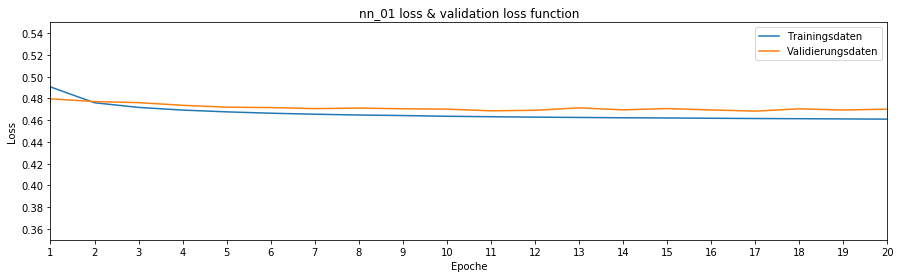

In [9]:
#Plotten des Graphs von loss und val_loss
plt.figure(figsize=(15, 4))
plt.ylabel("Loss")
plt.xlabel("Epoche")
plt.title("nn_01 loss & validation loss function")
plt.xticks(range(1, 21))
plt.yticks(np.linspace(0.36,0.54,10))
plt.axis([1, 20, 0.35, 0.55])
plt.plot([0] + history_nn_01.history["loss"])
plt.plot([0] + history_nn_01.history["val_loss"])
plt.legend(["Trainingsdaten", "Validierungsdaten"])
plt.savefig("img/plots/nn_01_loss_function.png")
plt.show()

#### *nn_02*

In [10]:
#Initialisierung von nn_02
nn_02 = Sequential()
nn_02.add(Dense(128, activation='relu', input_dim = 200))
nn_02.add(Dense(128, activation='relu'))
nn_02.add(Dense(1, activation='sigmoid'))
nn_02.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Starte Training von nn_02 - history_nn_02 speichert die Ergebnisse jeder Epoche
history_nn_02 = nn_02.fit(train_vecs, y_train, validation_data = (validation_vecs, y_validation), epochs = 20, batch_size = 32, verbose = 2)

Train on 1564371 samples, validate on 15963 samples
Epoch 1/20
 - 98s - loss: 0.4770 - acc: 0.7703 - val_loss: 0.4687 - val_acc: 0.7760
Epoch 2/20
 - 101s - loss: 0.4575 - acc: 0.7815 - val_loss: 0.4577 - val_acc: 0.7777
Epoch 3/20
 - 102s - loss: 0.4502 - acc: 0.7857 - val_loss: 0.4577 - val_acc: 0.7830
Epoch 4/20
 - 95s - loss: 0.4460 - acc: 0.7883 - val_loss: 0.4553 - val_acc: 0.7854
Epoch 5/20
 - 101s - loss: 0.4427 - acc: 0.7901 - val_loss: 0.4540 - val_acc: 0.7819
Epoch 6/20
 - 98s - loss: 0.4402 - acc: 0.7914 - val_loss: 0.4582 - val_acc: 0.7846
Epoch 7/20
 - 91s - loss: 0.4381 - acc: 0.7925 - val_loss: 0.4546 - val_acc: 0.7856
Epoch 8/20
 - 87s - loss: 0.4364 - acc: 0.7936 - val_loss: 0.4576 - val_acc: 0.7837
Epoch 9/20
 - 93s - loss: 0.4351 - acc: 0.7942 - val_loss: 0.4578 - val_acc: 0.7839
Epoch 10/20
 - 90s - loss: 0.4338 - acc: 0.7952 - val_loss: 0.4573 - val_acc: 0.7835
Epoch 11/20
 - 91s - loss: 0.4327 - acc: 0.7958 - val_loss: 0.4600 - val_acc: 0.7811
Epoch 12/20
 - 89s 

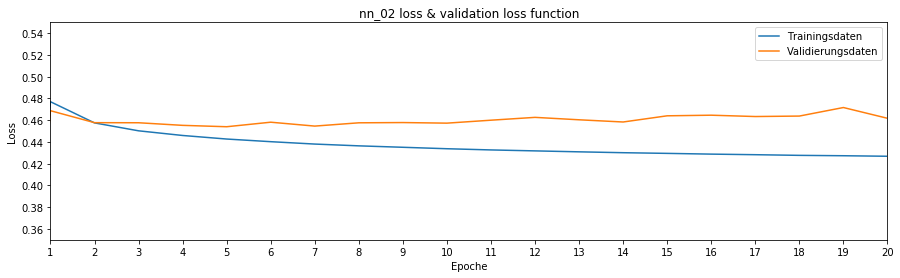

In [11]:
#Plotten des Graphs von loss und val_loss
plt.figure(figsize=(15, 4))
plt.ylabel("Loss")
plt.xlabel("Epoche")
plt.title("nn_02 loss & validation loss function")
plt.xticks(range(1, 21))
plt.yticks(np.linspace(0.36,0.54,10))
plt.axis([1, 20, 0.35, 0.55])
plt.plot([0] + history_nn_02.history["loss"])
plt.plot([0] + history_nn_02.history["val_loss"])
plt.legend(["Trainingsdaten", "Validierungsdaten"])
plt.savefig("img/plots/nn_02_loss_function.png")
plt.show()

#### *nn_03*

In [8]:
#Initialisierung von nn_03
nn_03 = Sequential()
nn_03.add(Dense(256, activation='relu', input_dim = 200))
nn_03.add(Dense(256, activation='relu'))
nn_03.add(Dense(256, activation='relu'))
nn_03.add(Dense(1, activation='sigmoid'))
nn_03.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Starte Training von nn_03 - history_nn_03 speichert die Ergebnisse jeder Epoche
history_nn_03 = nn_03.fit(train_vecs, y_train, validation_data = (validation_vecs, y_validation), epochs = 20, batch_size = 32, verbose = 2)

Train on 1564371 samples, validate on 15963 samples
Epoch 1/20
 - 164s - loss: 0.4731 - acc: 0.7727 - val_loss: 0.4586 - val_acc: 0.7802
Epoch 2/20
 - 164s - loss: 0.4512 - acc: 0.7855 - val_loss: 0.4566 - val_acc: 0.7836
Epoch 3/20
 - 162s - loss: 0.4419 - acc: 0.7908 - val_loss: 0.4523 - val_acc: 0.7847
Epoch 4/20
 - 159s - loss: 0.4357 - acc: 0.7946 - val_loss: 0.4502 - val_acc: 0.7858
Epoch 5/20
 - 167s - loss: 0.4309 - acc: 0.7975 - val_loss: 0.4501 - val_acc: 0.7855
Epoch 6/20
 - 170s - loss: 0.4265 - acc: 0.8004 - val_loss: 0.4510 - val_acc: 0.7846
Epoch 7/20
 - 166s - loss: 0.4233 - acc: 0.8023 - val_loss: 0.4590 - val_acc: 0.7822
Epoch 8/20
 - 175s - loss: 0.4200 - acc: 0.8042 - val_loss: 0.4516 - val_acc: 0.7822
Epoch 9/20
 - 163s - loss: 0.4171 - acc: 0.8063 - val_loss: 0.4596 - val_acc: 0.7805
Epoch 10/20
 - 168s - loss: 0.4148 - acc: 0.8078 - val_loss: 0.4552 - val_acc: 0.7829
Epoch 11/20
 - 173s - loss: 0.4127 - acc: 0.8093 - val_loss: 0.4574 - val_acc: 0.7822
Epoch 12/20

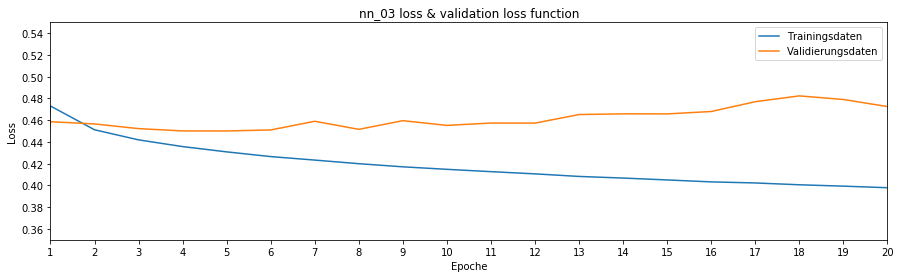

In [10]:
#Plotten des Graphs von loss und val_loss
plt.figure(figsize=(15, 4))
plt.ylabel("Loss")
plt.xlabel("Epoche")
plt.title("nn_03 loss & validation loss function")
plt.xticks(range(1, 21))
plt.yticks(np.linspace(0.36,0.54,10))
plt.axis([1, 20, 0.35, 0.55])
plt.plot([0] + history_nn_03.history["loss"])
plt.plot([0] + history_nn_03.history["val_loss"])
plt.legend(["Trainingsdaten", "Validierungsdaten"])
plt.savefig("img/plots/nn_03_loss_function.png")
plt.show()

Die beste maximale **Accuracy von 78.58%** auf den Validierungsdaten von den drei getesteten Modellen liefert Modell *nn_03* in Epoche 4. Dabei muss darauf geachtet werden, dass es hier mit fortschreitendem Training zu starkem Overfitting kommt. Nun wird das Modell *nn_03* ein weiteres Mal unter der Verwendung der *Callback Function* von Keras trainiert. Durch die Verwendung dieser Funktion wird das Modell zum Zeitpunkt der maximalen Accuracy gespeichert. Mithilfe der Funktion *checkpoint* wird das Modell gespeichert und während der Laufzeit immer überschrieben, wenn in einer weiteren Epoche eine höhere *val_acc* erreicht wird. Die Funktion *early_stop* bricht das Training ab, wenn es nach 5 Epochen zu keiner Erhöhung der Accuracy kam.

In [13]:
#Definieren der checkpoint und early_stop Funktion
checkpoint = ModelCheckpoint('models/nn/nn_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
#Initialisierung des finalen Neuronalen Netzes
nn = Sequential()
nn.add(Dense(256, activation='relu', input_dim = 200))
nn.add(Dense(256, activation='relu'))
nn.add(Dense(256, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Starte Training von nn mit ausreichend vielen Epochen
nn.fit(train_vecs, y_train, validation_data = (validation_vecs, y_validation), epochs = 100, batch_size = 32, verbose = 2, callbacks = callbacks_list)

Train on 1564371 samples, validate on 15963 samples
Epoch 1/100
 - 179s - loss: 0.4732 - acc: 0.7726 - val_loss: 0.4608 - val_acc: 0.7808

Epoch 00001: val_acc improved from -inf to 0.78081, saving model to models/nn/nn_model.h5
Epoch 2/100
 - 162s - loss: 0.4508 - acc: 0.7857 - val_loss: 0.4565 - val_acc: 0.7819

Epoch 00002: val_acc improved from 0.78081 to 0.78193, saving model to models/nn/nn_model.h5
Epoch 3/100
 - 172s - loss: 0.4417 - acc: 0.7908 - val_loss: 0.4475 - val_acc: 0.7868

Epoch 00003: val_acc improved from 0.78193 to 0.78682, saving model to models/nn/nn_model.h5
Epoch 4/100
 - 167s - loss: 0.4356 - acc: 0.7945 - val_loss: 0.4491 - val_acc: 0.7865

Epoch 00004: val_acc did not improve from 0.78682
Epoch 5/100
 - 179s - loss: 0.4310 - acc: 0.7972 - val_loss: 0.4488 - val_acc: 0.7907

Epoch 00005: val_acc improved from 0.78682 to 0.79070, saving model to models/nn/nn_model.h5
Epoch 6/100
 - 174s - loss: 0.4270 - acc: 0.7998 - val_loss: 0.4514 - val_acc: 0.7879

Epoch 0

In [14]:
#Laden des Modells aus Epoche 5 mit höchster Accuracy - gespeichert durch die Callback Funktion
nn_best = load_model('models/nn/nn_model.h5')

In [15]:
#Accuracy und Loss auf den Validierungsdaten
nn_best.evaluate(validation_vecs, y_validation)

15963/15963 [==============================] - 1s 53us/step


[0.4487690910102356, 0.79070350182188609]

In [17]:
#Accuracy und Loss auf den Testdaten
nn_best.evaluate(test_vecs, y_test)

15963/15963 [==============================] - 1s 65us/step


[0.45438261651338613, 0.7837499216789815]

Somit erzielt das finale neuronale Netz auf den Validierungsdaten eine **Accuracy von 79.07%** und auf den Testdaten eine **Accuracy von 78.37%**.

### 3.5 - Convolutional Neural Networks

Convolutional Neural Networks (dt. in etwa: "faltende neuronale Netze") stellen eine andere Art von künstlichen neuronalen Netzen dar. CNNs haben ihren Ursprung in der Bildverarbeitung, werden aber vermehrt auch in anderen Bereichen eingesetzt. Ein CNN besteht im Wesentlichen aus dem Embedding Layer, mehreren Convolutional Layer, Aggregations-Schichten (Pooling Layer) und am Ende aus einer oder mehreren Schichten von "normalen" vollständig verbundenen Neuronen bzw. Layer (Dense / Fully Connected Layer). Die Convolutional und Pooling Layer können mehrfach hintereinander platziert werden.
<br>
<img src="img/cnn.png" align="center" style="width: 650px;"/>
<br>
Um einem CNN die Tweets in numerischer Form übergeben zu können, wird eine einheitliche Formatierung der Daten benötigt. Das bedeutet jeder Tweet muss unabhängig von der enthaltenen Wortanzahl die gleiche Größe besitzen. Dazu wird den 100.000 häufigsten Wörter ein eindeutiger Index zugeordent.  Diese Anzahl wurde gewählt, da das Word2Vec Modell auf jeden Fall für diese Wörter Vektoren erstellt hat und diese im zweiten Schritt mit dem CNN kombiniert werden. Um eine einheitliche Größe der Vektoren zu erreichen, werden Tweets, die weniger Wörter enthalten, mit der entsprechenden Anzahl an Nullen aufgefüllt. Dem Wert Null ist kein Wort zugeordnet. Somit wird jeder Tweet durch eine Sequenz ganzzahliger positiver Werte repräsentiert. Diese Vektoren werden im Anschluss an das CNN übergeben. Der Embedding Layer des CNN enthält für alle Wörter eine Vektordarstellung der Länge 200 (entspricht Länge der Word2Vec Vektoren). Der Embedding Layer enthält also 100.000 Vektoren. Diese Vektoren werden den jeweiligen Wörtern bzw. den entsprechenden Indizes der Wörter eines Tweets zugeordnet, sodass ein Tweet als Matrix dargestellt wird. Diese wird dann an den Convolutional Layer übergeben. Der Wert 0 ist dem Nullvektor zugeordnet. <br>
Im ersten Ansatz werden die Vektoren des Embedding Layer vom Modell selbst gelernt. Die Vektoren werden dabei zufällig initialisiert und im Laufe des Trainings verbessert.
<br>
Im zweiten und dritten Ansatz werden die Vektoren des Word2Vec Modell für den Embedding Layer vorgegeben. Jedes Wort wird also seinem Word2Vec Vektor zugeordnet. Im zweiten Ansatz werden diese Vektoren nicht aktualisiert, im dritten Ansatz hingegen trainiert das Modell diese Vektoren mit.
<br>
<img src="img/embedding_layer.jpg" align="center" style="width: 650px;"/>
<br>
Aus Laufzeitgründen werden im Folgenden lediglich CNNs mit einer einfachen Struktur betrachtet. Durch die Verwendung eines 1D Conv-Layer entspricht die Länge der angewendeten Filter der Länge der Zeilen bzw. Anzahl der Spalten der Tweet-Matrix, also 200. Somit wird der Filter jeweils auf die komplette Wortrepräsentation (also nicht nur auf einen Teil davon) angewendet. Es werden 100 Filter mit der Dimension 2x200 angewendet. Dadurch werden je Filterschritt zwei Worte betrachtet.


Im Folgenden werden diese drei verschiedenen Ansätze betrachtet:
* *cnn_01*: CNN ohne vorgegebene Word2Vec Vektoren
* *cnn_02*: CNN mit statischen Word2Vec Vektoren
* *cnn_03*: CNN mit trainierbaren Word2Vec Vektoren

Zunächst werden die Tweets entsprechend vorbereitet. Bei Betrachtung des Outputs der nächsten Zellen wird deutlich wie die Tweets bearbeitet werden. Die [Keras Dokumentation](https://keras.io/preprocessing/text/) beschreibt das Data Preprocessing. Verwendet werden der *Keras-Tokenizer* und die Funktion *pad_sequences( )*.

In [6]:
#Tokenizer weißt den 100000 häufigsten Wörtern aus x_train Index zu
tokenizer = Tokenizer(num_words = 100000)
tokenizer.fit_on_texts(x_train)
#Jeder Tweet aus x_train wird als Vektor von Indizes der Wörter geschrieben
sequences = tokenizer.texts_to_sequences(x_train)

In [7]:
#Erster Tweet aus Trainingsdaten
x_train[x_train.index[0]]

'cool it is looks cute well let me kno what time because i will go wit u guys i am just need get ready amp eat'

In [8]:
#Erster Tweet aus Trainingsdaten als Vektor der Wort-Indizes
for i in sequences[0]: print(i, end =" ")

188 6 4 258 340 73 156 18 1194 51 54 120 1 29 41 894 57 193 1 11 22 88 38 194 64 351 

Nun liegen alle Tweets in Form von ganzen Zahlen für jedes Wort vor. Um die Vektoren als Input für das CNN zu nutzen ist es jedoch erforderlich, dass die Vektoren alle die gleiche Länge haben. Dazu werden in allen Vektoren, die kürzer als die Maximallänge sind, so viele Null-Einträge vorangestellt, bis sie der Maximallänge entsprechen. Da die maximale Anzahl der Worte eines einzelnen Tweets 53 beträgt und zusätzlich 5 Einträge als Spielraum dienen sollen, ergibt sich eine Gesamtlänge von 58.

In [9]:
length = []
for i in x_train:
    length.append(len(i.split())) #Länge des i-ten Tweets
#Maximum aller Längen + 5 Einträge Spielraum
max(length) + 5

58

In [10]:
#Alle Vektoren der Tweets werden mit Nullen aufgefüllt, sodass alle die Länge 58 besitzen
x_train_seq = pad_sequences(sequences, maxlen = 58)
#Erster Tweet aus Trainingsdaten als Vektor der Wort-Indizes mit maximaler Länge
for i in x_train_seq[0]: print(i, end =" ")

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 188 6 4 258 340 73 156 18 1194 51 54 120 1 29 41 894 57 193 1 11 22 88 38 194 64 351 

Die Matrix *x_train_seq* enthält nun die entsprechenden Tweets aus *x_train* in der Darstellung als Vektor der Wort-Indizes mit gleicher Länge.
Die Validierungs- und Testdaten werden ebenfalls in der selben Form benötigt.

In [11]:
#Validierungsdaten
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen = 58)
#Testdaten
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen = 58)

Für die Auswahl der Architektur der CNNs wird an dieser Stelle auf die Arbeiten von [Zhang und Wallace (2016)](https://arxiv.org/pdf/1510.03820.pdf) und [Kim (2014)](https://arxiv.org/pdf/1408.5882.pdf) verwiesen.  Diese komplexeren Modelle werden in vielen Projekten angewendet und können vermutlich eine bessere Accuracy erreichen. In der vorliegenden Arbeit wurde aufgrund der deutlich längeren Laufzeit von einer Implementierung abgesehen.
<br><br>
Im Folgenden wird ein einfaches CNN mit den eben erstellten Vektoren trainiert. Die Vektoren des Embedding Layers, welche alle Worte repräsentieren, werden vom Modell selbst gelernt. Das Modelltraining fand aufgrund der extrem langen Trainingsdauer von über 24 Stunden in einem anderen Jupyter Notebook und auf einem Server statt.

#### cnn_1

In [ ]:
#Initialisierung cnn_01
cnn_01 = Sequential()
#Embedding Layer mit 100000 x 200
cnn_01.add(Embedding(100000, 200, input_length=58))
#Convolutional Layer
cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
#Pooling Layer
cnn_01.add(GlobalMaxPooling1D()) 
cnn_01.add(Dense(256, activation='relu'))
cnn_01.add(Dense(1, activation='sigmoid'))
cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_01 = cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=10, batch_size=32, verbose=2)

Output des obenstehenden Codes:<br>
*Epoche 01 - loss: 0.4073 - acc: 0.8136 - val_loss: 0.3877 - val_acc: 0.8215<br>
Epoche 02 - loss: 0.3609 - acc: 0.8399 - val_loss: 0.3806 - val_acc: 0.8260<br>
Epoche 03 - loss: 0.3308 - acc: 0.8568 - val_loss: 0.3896 - val_acc: 0.8236<br>
Epoche 04 - loss: 0.3035 - acc: 0.8713 - val_loss: 0.3993 - val_acc: 0.8211<br>
Epoche 05 - loss: 0.2782 - acc: 0.8841 - val_loss: 0.4163 - val_acc: 0.8208<br>
Epoche 06 - loss: 0.2554 - acc: 0.8947 - val_loss: 0.4352 - val_acc: 0.8151<br>
Epoche 07 - loss: 0.2353 - acc: 0.9039 - val_loss: 0.4618 - val_acc: 0.8131<br>
Epoche 08 - loss: 0.2179 - acc: 0.9116 - val_loss: 0.5114 - val_acc: 0.8026<br>
Epoche 09 - loss: 0.2033 - acc: 0.9179 - val_loss: 0.5086 - val_acc: 0.8087<br>
Epoche 10 - loss: 0.1904 - acc: 0.9233 - val_loss: 0.5362 - val_acc: 0.8034*<br>
max val_acc: 0.8260 in Epoche 2

In [21]:
#Manuelles Einlesen der loss und val_loss Werte zum plotten
loss_cnn_01 = [0.4073, 0.3609, 0.3308, 0.3035, 0.2782, 0.2554, 0.2353, 0.2179, 0.2033, 0.1904]
val_loss_cnn_01 = [0.3877, 0.3806, 0.3896, 0.3993, 0.4163, 0.4352, 0.4618, 0.5114, 0.5086, 0.5362]

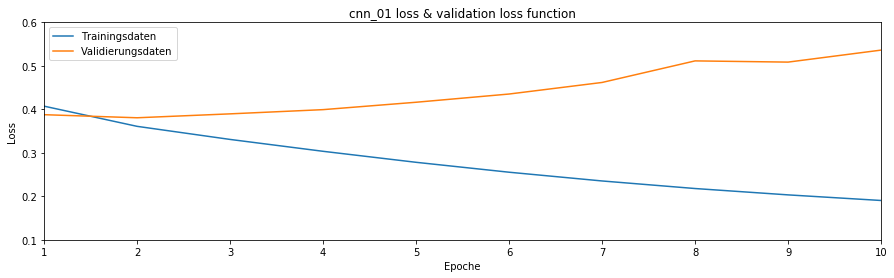

In [22]:
#Plotten des Graphs von loss und val_loss
plt.figure(figsize=(15, 4))
plt.ylabel("Loss")
plt.xlabel("Epoche")
plt.title("cnn_01 loss & validation loss function")
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0.1,0.6,6))
plt.axis([1, 10, 0.1, 0.6])
plt.plot([0] + loss_cnn_01)
plt.plot([0] + val_loss_cnn_01)
plt.legend(["Trainingsdaten", "Validierungsdaten"])
plt.savefig("img/plots/cnn_01_loss_function.png")
plt.show()

Der Plot der Loss- und Validation-Loss-Funktion zeigt deutlich, dass die beiden Funktionen sich auseinander bewegen. Während der loss-Wert kontinuierlich kleiner wird, steigt der val_loss-Wert recht deutlich an. Dies ist ein klarer Hinweis für ein Overfitting des Modells. Dementsprechend muss das Training frühzeitig beendet werden (In diesem Fall weist das Modell in der zweiten Epoche die höchste Validierungs-Accuracy auf, zu diesem Zeitpunkt ist noch kein Overfitting vorhanden).

Mit dem einfachen CNN konnte eine maximale **Accuracy von 82.60%** auf den Validierungsdaten erzielt werden. Somit konnten bereits deutlich bessere Ergebnisse als mit den einfachen Neuronalen Netzen erreicht werden.

Im Folgenden wird nun versucht dieses Ergebnis weiter zu verbessern. Dafür werden die Vektoren aus dem Word2Vec Modell für die CNNs verwendet.

In [11]:
#Laden der Vektoren des Word2Vec Modells
w2v_model = KeyedVectors.load('models/word2vec/model.word2vec')
# Anzahl aller Wörter
len(w2v_model.wv.vocab)

106225

Das Word2Vec Modell enthält Vektoren für die ersten 106.225 häufigsten Wörter. Deshalb werden, wie bereits zuvor beschrieben, nur die 100.000 häufigsten Wörter betrachtet. Würden viel mehr Wörter betrachtet werden, gäbe es für diese keine Vektoren aus Word2Vec mehr.<br>
Es wird das Dictionary *embeddings_index* erstellt, welches jedem Wort den entsprechenden Vektor zuweißt.

In [12]:
embeddings_index = {}
for w in w2v_model.wv.vocab.keys(): #w ist Wort
    embeddings_index[w] = w2v_model.wv[w] #Dictionary an der Stelle w entspricht w2v Vektor des Wortes w

Daraufhin wird die Matrix *embedding_matrix* erstellt. Jede Zeile steht jeweils für den Index eines Wortes. In dieser Zeile wird der Vektor des entsprechenden Wortes aus *embeddings_index* gespeichert. Es ensteht so eine Matrix mit der Dimension 100.000 (Anzahl der betrachteten Wörter) x 200 (Länge der Vektoren aus Word2Vec)

In [13]:
# Erstellen der embedding_matrix mit allen Wörtern als Vektoren
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_matrix[i] = embeddings_index.get(word)

In [14]:
embedding_matrix.shape

(100000, 200)

Nun kann überprüft werden, ob alles korrekt funktioniert hat. Wie vorher in der Beispielausgabe gezeigt steht der Index *188* für das Wort *"cool"*. In Zeile 188 der Matrix *embedding_matrix* muss jetzt der Vektor für das Wort *"cool"* stehen.

In [15]:
#Wenn Ausgabe == True stimmen die Vektoren überein
np.array_equal(embedding_matrix[188], embeddings_index.get("cool"))

True

#### *cnn_02*

In diesem CNN werden für den Embedding Layer die Word2Vec Vektoren vorgegeben (*embedding_matrix*). Die Vektoren werden während des Trainings nicht aktualisiert. Aufgrund der langen Trainingsdauer wurde dieses Modell wieder in einer externen Datei auf einem Server trainiert. Der Output des untenstehenden Codes befindet sich im Folgenden.

In [ ]:
cnn_02 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=58, trainable=False)
cnn_02.add(e)
cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn_02.add(GlobalMaxPooling1D())
cnn_02.add(Dense(256, activation='relu'))
cnn_02.add(Dense(1, activation='sigmoid'))
cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_02 = cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=10, batch_size=32, verbose=2)

Output des obenstehenden Codes:<br>
*Epoche 01 - loss: 0.4169 - acc: 0.8076 - val_loss: 0.4052 - val_acc: 0.8119<br>
Epoche 02 - loss: 0.3954 - acc: 0.8202 - val_loss: 0.3944 - val_acc: 0.8173<br>
Epoche 03 - loss: 0.3877 - acc: 0.8247 - val_loss: 0.3975 - val_acc: 0.8172<br>
Epoche 04 - loss: 0.3829 - acc: 0.8269 - val_loss: 0.3986 - val_acc: 0.8154<br>
Epoche 05 - loss: 0.3794 - acc: 0.8291 - val_loss: 0.3934 - val_acc: 0.8205<br>
Epoche 06 - loss: 0.3767 - acc: 0.8305 - val_loss: 0.4018 - val_acc: 0.8166<br>
Epoche 07 - loss: 0.3745 - acc: 0.8318 - val_loss: 0.3965 - val_acc: 0.8182<br>
Epoche 08 - loss: 0.3730 - acc: 0.8325 - val_loss: 0.3892 - val_acc: 0.8215<br>
Epoche 09 - loss: 0.3717 - acc: 0.8333 - val_loss: 0.3938 - val_acc: 0.8194<br>
Epoche 10 - loss: 0.3705 - acc: 0.8339 - val_loss: 0.3931 - val_acc: 0.8213*<br>
max val_acc: 0.8215 in Epoche 8

In [23]:
#Manuelles Einlesen der loss und val_loss Werte zum plotten
loss_cnn_02 = [0.4169 ,0.3954 ,0.3877 ,0.3829 ,0.3794 ,0.3767 ,0.3745 ,0.3730 ,0.3717 ,0.3705]
val_loss_cnn_02 = [0.4052, 0.3944, 0.3975, 0.3986, 0.3934, 0.4018, 0.3965, 0.3892, 0.3938, 0.3931]

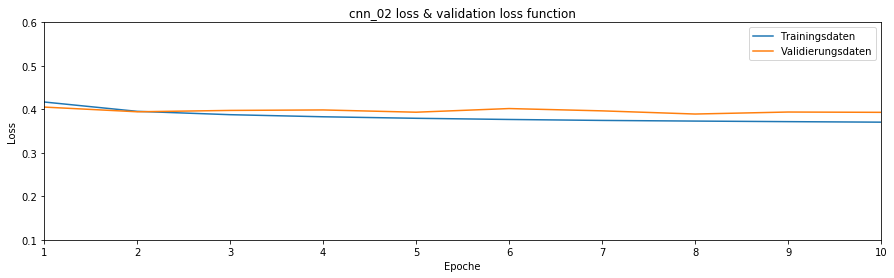

In [24]:
#Plotten des Graphs von loss und val_loss
plt.figure(figsize=(15, 4))
plt.ylabel("Loss")
plt.xlabel("Epoche")
plt.title("cnn_02 loss & validation loss function")
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0.1,0.6,6))
plt.axis([1, 10, 0.1, 0.6])
plt.plot([0] + loss_cnn_02)
plt.plot([0] + val_loss_cnn_02)
plt.legend(["Trainingsdaten", "Validierungsdaten"])
plt.savefig("img/plots/cnn_02_loss_function.png")
plt.show()

#### *cnn_03*

Wieder werden dem Embedding Layer die Word2Vec Vektoren vorgegeben. Diesmal können die Vektoren aber während des Trainings aktualisiert werden. Aufgrund der extrem langen Trainingsdauer wurde dieses Modell wieder in einer externen Datei auf einem Server trainiert.

In [ ]:
cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=58, trainable=True)
cnn_03.add(e)
cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn_03.add(GlobalMaxPooling1D())
cnn_03.add(Dense(256, activation='relu'))
cnn_03.add(Dense(1, activation='sigmoid'))
cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_03 = cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=10, batch_size=32, verbose=2)

Output des obenstehenden Codes:<br>
*Epoche 01 - loss: 0.4018 - acc: 0.8164 - val_loss: 0.3849 - val_acc: 0.8246<br>
Epoche 02 - loss: 0.3636 - acc: 0.8383 - val_loss: 0.3799 - val_acc: 0.8250<br>
Epoche 03 - loss: 0.3383 - acc: 0.8520 - val_loss: 0.3820 - val_acc: 0.8263<br>
Epoche 04 - loss: 0.3139 - acc: 0.8651 - val_loss: 0.3998 - val_acc: 0.8255<br>
Epoche 05 - loss: 0.2900 - acc: 0.8771 - val_loss: 0.3978 - val_acc: 0.8211<br>
Epoche 06 - loss: 0.2679 - acc: 0.8875 - val_loss: 0.4189 - val_acc: 0.8205<br>
Epoche 07 - loss: 0.2479 - acc: 0.8969 - val_loss: 0.4516 - val_acc: 0.8161<br>
Epoche 08 - loss: 0.2303 - acc: 0.9046 - val_loss: 0.4711 - val_acc: 0.8098<br>
Epoche 09 - loss: 0.2151 - acc: 0.9113 - val_loss: 0.4875 - val_acc: 0.8064<br>
Epoche 10 - loss: 0.2020 - acc: 0.9167 - val_loss: 0.4986 - val_acc: 0.8047*<br>
max val_acc: 0.8263 in Epoche 3

In [25]:
#Manuelles Einlesen der loss und val_loss Werte zum plotten
loss_cnn_03 = [0.4018, 0.3636, 0.3383, 0.3139, 0.2900, 0.2679, 0.2479, 0.2302, 0.2151, 0.2020]
val_loss_cnn_03 = [0.3849, 0.3799, 0.3820, 0.3998, 0.3978, 0.4189, 0.4516, 0.4711, 0.4875, 0.4985]

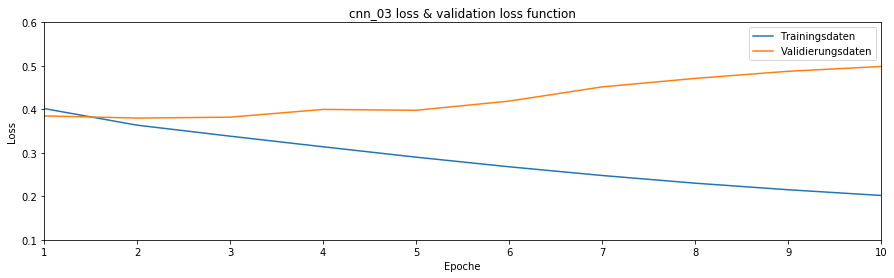

In [26]:
#Plotten des Graphs von loss und val_loss
plt.figure(figsize=(15, 4))
plt.ylabel("Loss")
plt.xlabel("Epoche")
plt.title("cnn_03 loss & validation loss function")
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0.1,0.6,6))
plt.axis([1, 10, 0.1, 0.6])
plt.plot([0] + loss_cnn_03)
plt.plot([0] + val_loss_cnn_03)
plt.legend(["Trainingsdaten", "Validierungsdaten"])
plt.savefig("img/plots/cnn_03_loss_function.png")
plt.show()

Die beste maximale **Accuracy von 82.63%** auf den Validierungsdaten von den drei Modellen liefert Modell *cnn_03* in Epoche 3. Mit längerem Training sieht man auch hier sehr starkes Overfitting. Nun wird das Modell *nn_03* ein weiteres Mal unter der Verwendung der *Callback Function* von Keras trainiert um das Modell in der besten Epoche zu speichern. Das Vorgehen dabei ist analog zu den einfachen Neuronalen Netzen. Ausgeführt wird der unten stehende Code aufgrund der langen Trainingsdauer wieder in einer externen Datei auf dem Server.

In [ ]:
checkpoint = ModelCheckpoint('models/cnn/cnn_model-e{epoch:02d}.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=58, trainable=True)
cnn_03.add(e)
cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn_03.add(GlobalMaxPooling1D())
cnn_03.add(Dense(256, activation='relu'))
cnn_03.add(Dense(1, activation='sigmoid'))
cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=100, batch_size=32, verbose=2, callbacks = callbacks_list)

In [13]:
#Laden des Modells aus der dritten Epoche mit höchster Accuracy - gespeichert durch die Callback Funktion
cnn_best = load_model('models/cnn/cnn_model-e03.h5')

In [15]:
#Accuracy und Loss auf den Validierungsdaten
cnn_best.evaluate(x_val_seq, y_validation)

15963/15963 [==============================] - 2s 107us/step


[0.37625320618600538, 0.83054563683360649]

In [16]:
#Accuracy und Loss auf den Testdaten
cnn_best.evaluate(x_test_seq, y_test)

15963/15963 [==============================] - 2s 101us/step


[0.38660272230392845, 0.82628578589104895]

Somit erzielt das finale CNN auf den Validierungsdaten eine **Accuracy von 83.05%** und auf den Testdaten eine **Accuracy von 82.63%**.

## 4. Sentiment-Analyse der gesammelten Tweets

Nun liegen drei verschiedene trainierte Modelle vor: 
* VADER Sentiment mit **Accuracy von 66.67%**
* Neuronales Netz mit **Accuracy von 78.37%**
* Convolutional Neural Network mit **Accuracy von 82.63%**

Im Folgenden werden diese Modelle auf die gesammelten Tweets zu **#apple** und **#tesla** angewendet. Die graphische Darstellung und Beurteilung der Ergebnisse erfolgt in *Kapitel 5.1 Ergebnisse*.

In [15]:
#Einlesen der vorbereiteten Daten von #apple
data_apple = pd.read_csv("data/clean/data_apple.csv", index_col = 0)
data_apple.head()

,date,text
0,Tue Nov 13,check it out a chain of flames by tony cleaver...
1,Tue Nov 13,did you submit order for today it s november a...
2,Tue Nov 13,reposting sudo html css javascript python ruby...
3,Tue Nov 13,the bigger they come the harder they fall we r...
4,Tue Nov 13,any advice apple timemachine


In [16]:
#Einlesen der vorbereiteten Daten von #tesla
data_tesla = pd.read_csv("data/clean/data_tesla.csv", index_col = 0)
data_tesla.head()

,date,text
0,Tue Nov 13,now that is how you make a tesla look aggressi...
1,Tue Nov 13,like i said in passed i am the bliss trump is ...
2,Tue Nov 13,of course tesla potentially the most dominant ...
3,Tue Nov 13,almost all the misconceptions about autopilot ...
4,Tue Nov 13,of course tesla potentially the most dominant ...


### 4.1 VADER Sentiment

Die Rückgabe der Methode *getSentimentVader( )* ist ein Vektor, der den durschnittlichen Sentiment Score pro Tag, enthält. Dieser kann zwischen -1 und 1 liegen und wird zur besseren Vergleichbarkeit mit den anderen Modellen auf [0, 1] normiert. Zusätzlich wird die Anzahl der Tweets pro Tag zurückgegeben. Für die Auswertung das Verhältnis von positiven zu negativen Tweets zu verwenden ist hier nicht sinnvoll. Da neutral klassifizierte Tweets als positive Tweets gezählt werden, würde dies zu einer starken Verzerrung des Gesamtsentiments führen.

In [19]:
def getSentimentVADER(data):
    mean = []
    sentiment = []
    sent_date = []
    count = []
    #Erzeugung VADER Instanz
    sid = SentimentIntensityAnalyzer()
    for i in range(len(data.text)):
        if (i + 1) % 10000 == 0:
            print("Iteration: {} von {}".format(i + 1, len(data.text)))
        #In mean wird jeweils der Sentiments Score aller Tweets eines Tages gespeichert
        mean.append(sid.polarity_scores(data.text[i])['compound'])
        #Letzer Tweet
        if i == len(data) - 1:
            sentiment.append(((sum(mean) / len(mean) + 2) / 2)-0.5 )
            sent_date.append(data.date[i])
            count.append(len(mean)) #Anzahl der Tweets am letzen Tag
            break
        #Datum des vorherigen Tweets entspricht nicht dem Datum des nächsten Tweets
        if data.date[i] != data.date[i + 1]:
            sentiment.append(((sum(mean) / len(mean) + 2) / 2)-0.5 ) #Sentiment eines Tages wird gemittelt
            sent_date.append(data.date[i]) #Hinzufügen des Datums in count
            count.append(len(mean)) #Anzahl der Tweets ist Anzahl der Sentiment Scores
            mean = [] #Tweets eines Tages werden zurückgesetz
    print("Iteration: {} von {}".format(len(data.text), len(data.text)))
    #sentiment enthält durchschnittlichen sentiment score pro Tag
    #sent_date enthält Datum des jeweiligen Tags
    #count enthält die Anzahl der Tweets pro Tag
    return sentiment, sent_date, count 

#### VADER - #apple

In [20]:
#VADER wird auf die Apple Tweets angewendet
sentiment_apple, date_apple, count_apple = getSentimentVADER(data_apple)

Iteration: 10000 von 84890
Iteration: 20000 von 84890
Iteration: 30000 von 84890
Iteration: 40000 von 84890
Iteration: 50000 von 84890
Iteration: 60000 von 84890
Iteration: 70000 von 84890
Iteration: 80000 von 84890
Iteration: 84890 von 84890


In [21]:
#Plot der Apple Tweets erstellen (VADER)
fig = plt.figure(figsize=(20, 5))
fig.suptitle("VADER Sentiment - #apple", fontsize=20)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
gs.update(hspace=0)

#Graph der durchschnittlichen Sentiment Score pro Tag plottet (sentiment_apple)
ax1 = plt.subplot(gs[0])
plt.plot(sentiment_apple, color = 'white')
plt.fill_between(range(len(date_apple)) ,sentiment_apple, 0.0, color="green", alpha=0.5)
plt.fill_between(range(len(date_apple)) , 1.0, sentiment_apple, color="red", alpha=0.5)
plt.margins(x=0)
plt.xticks(range(len(date_apple)), date_apple, rotation='vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.ylabel("sentiment score")

#Balkendiagramm mit Anzahl der Tweets pro Tag
ax2 = plt.subplot(gs[1], sharex=ax1)
plt.xticks(range(len(date_apple)), date_apple, rotation='vertical')
plt.bar(range(len(date_apple)), count_apple, align='center', alpha=0.5)
plt.margins(x=0)
plt.ylabel("Anzahl")

#Plot wird als Bild gespeichert
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig("img/plots/vader_apple.png")

#### VADER - #tesla

In [22]:
#VADER wird auf die Tesla Tweets angewendet
sentiment_tesla, date_tesla, count_tesla = getSentimentVADER(data_tesla)

Iteration: 10000 von 41395
Iteration: 20000 von 41395
Iteration: 30000 von 41395
Iteration: 40000 von 41395
Iteration: 41395 von 41395


In [23]:
#Plot der Tesla Tweets erstellen (VADER)
fig = plt.figure(figsize=(20, 5))
fig.suptitle("VADER Sentiment - #tesla", fontsize=20)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
gs.update(hspace=0)

#Graph der durchschnittlichen Sentiment Score pro Tag plottet (sentiment_tesla)
ax1 = plt.subplot(gs[0])
plt.plot(sentiment_tesla, color = 'white')
plt.fill_between(range(len(date_tesla)) ,sentiment_tesla, 0.0, color="green", alpha=0.5)
plt.fill_between(range(len(date_tesla)) , 1.0, sentiment_tesla, color="red", alpha=0.5)
plt.margins(x=0)
plt.xticks(range(len(date_tesla)), date_tesla, rotation='vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.ylabel("sentiment score")

#Balkendiagramm mit Anzahl der Tweets pro Tag
ax2 = plt.subplot(gs[1], sharex=ax1)
plt.xticks(range(len(date_tesla)), date_tesla, rotation='vertical')
plt.bar(range(len(date_tesla)), count_tesla, align='center', alpha=0.5)
plt.margins(x=0)
plt.ylabel("Anzahl")

#Plot wird als Bild gespeichert
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig("img/plots/vader_tesla.png")

### 4.2 Neuronales Netz

Im Folgenden wird das zuvor trainierte Doc2Vec Modell und das neuronale Netze geladen. Die Methode *getSentimentNN( )* wandelt die gesammelten Tweets auf Basis des Doc2Vec Modells erst in Vektoren um. Diese Vektoren dienen als Input für das neuronale Netz und werden dann entweder in negativ (*"0"*) oder postiv (*"1"*) klassifiziert. Zur Auswertung wird als Sentiment Maß jeweils das Verhältnis von positiven zu negativen Tweets pro Tag, sowie das entsprechende Datum gespeichert. 

In [24]:
#Doc2Vec Modell wird geladen und temporäre Daten des Modellss werden gelöscht
model= Doc2Vec.load("models/doc2vec/dbow.model")
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
#Neuronales Netz wird geladen
nn = load_model("models/nn/nn_model.h5")

In [25]:
def getSentimentNN(data):
    mean = []
    sentiment = []
    sent_date = []
    count = []
    pos_count = []
    for i in range(len(data)):
        if (i + 1) % 10000 == 0:
                print("Iteration: {} von {}".format(i + 1, len(data)))
        token_list = data.text[i].split(" ") #Tweet in einzelne Worte zerlegen
        #model.infer_vector(Liste von Worten) bestimmt den Doc2Vec Vektor des Tweets
        ivec = model.infer_vector(doc_words=token_list, steps=200, alpha=0.065)
        #predict_classes(Vektor) klassifiziert Ausgabe des NN direkt in "0" oder "1"
        mean.append(float(nn.predict_classes(np.array([ivec]))[0])) #Klasse wird zu mean hinzugefügt
        #Letzter Tweet
        if i == len(data) - 1:
            sentiment.append(sum(mean) / len(mean)) #Verhältnis von pos zu neg am letzen Tag
            sent_date.append(data.date[i]) #Datum letzter Tag
            count.append(len(mean)) #Anzahl Tweets letzter Tag
            pos_count.append(sum(mean)) #Anzahl positive Tweets letzer Tag
            break
        #Datum des nächsten Tweets entspricht nicht Datum des aktuellen Tweets
        if data.date[i] != data.date[i + 1]:
            sentiment.append(sum(mean) / len(mean)) #Verhältnis von pos zu neg des Tages
            sent_date.append(data.date[i]) #Datum des Tages
            count.append(len(mean)) #Anzahl der Tweets dieses Tages
            pos_count.append(sum(mean)) #Anzahl der positiven Tweets
            mean = [] #Tag wird zurückgesetzt
    print("Iteration: {} von {}".format(len(data.text), len(data.text)))
    return sentiment, sent_date, count, pos_count

#### NN - #apple

In [26]:
#Neuronales Netz mit Doc2Vec wird auf die Apple Tweets angewendet
sentiment_apple, date_apple, count_apple, pos_count_apple = getSentimentNN(data_apple)

Iteration: 10000 von 84890
Iteration: 20000 von 84890
Iteration: 30000 von 84890
Iteration: 40000 von 84890
Iteration: 50000 von 84890
Iteration: 60000 von 84890
Iteration: 70000 von 84890
Iteration: 80000 von 84890
Iteration: 84890 von 84890


In [27]:
#Plot der Apple Tweets erstellen (NN)
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Neuronales Netz - #apple", fontsize=20)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
gs.update(hspace=0)

#Graph der Verhältnis von positiven zu negativen Tweets plottet
ax1 = plt.subplot(gs[0])
plt.plot(sentiment_apple, color = 'white')
plt.fill_between(range(len(date_apple)) ,sentiment_apple, 0.0, color="green", alpha=0.5)
plt.fill_between(range(len(date_apple)) , 1.0, sentiment_apple, color="red", alpha=0.5)
plt.margins(x=0)
plt.xticks(range(len(date_apple)), date_apple, rotation='vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.ylabel("sentiment score")

#Balkendiagramm das Anzahl von positiven und negativen Tweets anzeigt
ax2 = plt.subplot(gs[1], sharex=ax1)
neg_count_apple = list(map(operator.sub, count_apple, pos_count_apple))
plt.xticks(range(len(date_apple)), date_apple, rotation='vertical')
plt.bar(range(len(date_apple)), pos_count_apple, align='center', alpha=0.5, color = 'green')
plt.bar(range(len(date_apple)), neg_count_apple, align='center', alpha=0.5, bottom=pos_count_apple, color = 'red')
plt.margins(x=0)
plt.ylabel("Anzahl")

# Plot wird als Bild gespeichert
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig("img/plots/nn_apple.png")

#### NN - #tesla

In [28]:
#Neuronales Netz mit Doc2Vec wird auf die Tesla Tweets angewendet
sentiment_tesla, date_tesla, count_tesla, pos_count_tesla = getSentimentNN(data_tesla)

Iteration: 10000 von 41395
Iteration: 20000 von 41395
Iteration: 30000 von 41395
Iteration: 40000 von 41395
Iteration: 41395 von 41395


In [29]:
#Plot der Tesla Tweets erstellen (NN)
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Neuronales Netz - #tesla", fontsize=20)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
gs.update(hspace=0)

#Graph der Verhältnis von positiven zu negativen Tweets plottet
ax1 = plt.subplot(gs[0])
plt.plot(sentiment_tesla, color = 'white')
plt.fill_between(range(len(date_tesla)) ,sentiment_tesla, 0.0, color="green", alpha=0.5)
plt.fill_between(range(len(date_tesla)) , 1.0, sentiment_tesla, color="red", alpha=0.5)
plt.margins(x=0)
plt.xticks(range(len(date_tesla)), date_tesla, rotation='vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.ylabel("sentiment score")

#Balkendiagramm das Anzahl von positiven und negativen Tweets anzeigt
ax2 = plt.subplot(gs[1], sharex=ax1)
neg_count_tesla = list(map(operator.sub, count_tesla, pos_count_tesla))
plt.xticks(range(len(date_tesla)), date_tesla, rotation='vertical')
plt.bar(range(len(date_tesla)), pos_count_tesla, align='center', alpha=0.5, color = 'green')
plt.bar(range(len(date_tesla)), neg_count_tesla, align='center', alpha=0.5, bottom=pos_count_tesla, color = 'red')
plt.margins(x=0)
plt.ylabel("Anzahl")

#Plot wird als Bild gespeichert
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig("img/plots/nn_tesla.png")

### 4.3 Convolutional Neural Network

Um das CNN auf die gesammelten Tweets anwenden zu können, müssen die Tweets wieder als Vektoren der zuvor beim Training des CNN festgelegten Indizes dargestellt werden. Die Vektoren werden durch das Voranstellen von Nullen wiederum alle auf die selbe Länge von 58 gebracht. Nun dienen die Vektoren als Input für das CNN und werden in negativ (*"0"*) oder postiv (*"1"*) klassifiziert. Zur Auswertung wird als Sentiment Maß jeweils das Verhältnis von positiven zu negativen Tweets pro Tag, sowie das entsprechende Datum gespeichert. Zusätzlich wird das durchschnittliche Sentiment über den gesamten Betrachtungszeitraum ausgegeben.

In [17]:
#CNN Modell wird geladen
cnn = load_model("models/cnn/cnn_model-e03.h5")

In [18]:
def getSentimentCNN(data):
    mean = []
    sentiment = []
    sent_date = []
    count = []
    pos_count = []
    for i in range(len(data)):
        if (i + 1) % 10000 == 0:
                print("Iteration: {} von {}".format(i + 1, len(data)))
        #Tweet als Vektor von Indizes darstellen
        sequences = tokenizer.texts_to_sequences([data.text[i]])
        #Vektor auf maximale Länge bringen
        pad_seq = pad_sequences(sequences, maxlen = 58)
        #Vektor klassifizieren
        mean.append(int(cnn.predict_classes(pad_seq)))
        if i == len(data) - 1:
            sentiment.append(sum(mean) / len(mean))
            sent_date.append(data.date[i])
            count.append(len(mean))
            pos_count.append(sum(mean))
            break
        if data.date[i] != data.date[i + 1]:
            sentiment.append(sum(mean) / len(mean))
            sent_date.append(data.date[i])
            count.append(len(mean))
            pos_count.append(sum(mean))
            mean = []
    print("Iteration: {} von {}".format(len(data.text), len(data.text)))
    return sentiment, sent_date, count, pos_count

#### CNN - #apple

In [19]:
#CNN wird auf die Apple Tweets angewendet
sentiment_apple, date_apple, count_apple, pos_count_apple = getSentimentCNN(data_apple)
#Durchschnittliches Sentiment über gesamten Betrachtungszeitraum
sum(sentiment_apple) / len(sentiment_apple)

Iteration: 10000 von 84890
Iteration: 20000 von 84890
Iteration: 30000 von 84890
Iteration: 40000 von 84890
Iteration: 50000 von 84890
Iteration: 60000 von 84890
Iteration: 70000 von 84890
Iteration: 80000 von 84890
Iteration: 84890 von 84890


0.69454998274334

In [20]:
#Plot der Apple Tweets erstellen (CNN)
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Convolutional Neural Network - #apple", fontsize=20)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
gs.update(hspace=0)

#Graph der Verhältnis von positiven zu negativen Tweets plottet
ax1 = plt.subplot(gs[0])
plt.plot(sentiment_apple, color = 'white')
plt.fill_between(range(len(date_apple)) ,sentiment_apple, 0.0, color="green", alpha=0.5)
plt.fill_between(range(len(date_apple)) , 1.0, sentiment_apple, color="red", alpha=0.5)
plt.margins(x=0)
plt.xticks(range(len(date_apple)), date_apple, rotation='vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.ylabel("sentiment score")

#Balkendiagramm das Anzahl von positiven und negativen Tweets anzeigt
ax2 = plt.subplot(gs[1], sharex=ax1)
neg_count_apple = list(map(operator.sub, count_apple, pos_count_apple))
plt.xticks(range(len(date_apple)), date_apple, rotation='vertical')
plt.bar(range(len(date_apple)), pos_count_apple, align='center', alpha=0.5, color = 'green')
plt.bar(range(len(date_apple)), neg_count_apple, align='center', alpha=0.5, bottom=pos_count_apple, color = 'red')
plt.margins(x=0)
plt.ylabel("Anzahl")

#Plot wird als Bild gespeichert
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig("img/plots/cnn_apple.png")

#### CNN - #tesla

In [21]:
#CNN wird auf die Tesla Tweets angewendet
sentiment_tesla, date_tesla, count_tesla, pos_count_tesla = getSentimentCNN(data_tesla)
#Durchschnittliches Sentiment über gesamten Betrachtungszeitraum
sum(sentiment_tesla) / len(sentiment_tesla)

Iteration: 10000 von 41395
Iteration: 20000 von 41395
Iteration: 30000 von 41395
Iteration: 40000 von 41395
Iteration: 41395 von 41395


0.7567762630658372

In [22]:
#Plot der Tesla Tweets erstellen (CNN)
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Convolutional Neural Network - #tesla", fontsize=20)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
gs.update(hspace=0)

#Graph der Verhältnis von positiven zu negativen Tweets plottet
ax1 = plt.subplot(gs[0])
plt.plot(sentiment_tesla, color = 'white')
plt.fill_between(range(len(date_tesla)) ,sentiment_tesla, 0.0, color="green", alpha=0.5)
plt.fill_between(range(len(date_tesla)) , 1.0, sentiment_tesla, color="red", alpha=0.5)
plt.margins(x=0)
plt.xticks(range(len(date_tesla)), date_tesla, rotation='vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.ylabel("sentiment score")

#Balkendiagramm das Anzahl von positiven und negativen Tweets anzeigt
ax2 = plt.subplot(gs[1], sharex=ax1)
neg_count_tesla = list(map(operator.sub, count_tesla, pos_count_tesla))
plt.xticks(range(len(date_tesla)), date_tesla, rotation='vertical')
plt.bar(range(len(date_tesla)), pos_count_tesla, align='center', alpha=0.5, color = 'green')
plt.bar(range(len(date_tesla)), neg_count_tesla, align='center', alpha=0.5, bottom=pos_count_tesla, color = 'red')
plt.margins(x=0)
plt.ylabel("Anzahl")

#Plot wird als Bild gespeichert
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig("img/plots/cnn_tesla.png")

## 5. Ergebnisse, Zusammenfassung und Ausblick

Das fünfte Kapitel dient der Vorstellung und Bewertung der Ergebnisse sowie einer Zusammenfassung der Arbeit.

### 5.1 Ergebnisse

Dargestellt werden im Folgenden die aus der Sentiment Analyse enstandenen Daten. Die Kurve zeigt den zeitlichen Verlauf des Sentiments der drei angewendeten Modelle. Das Balkendiagram macht die Anzahl der am jeweiligen Tag veröffentlichten Tweets und deren Sentimentklassifizierung deutlich.

#### Sentiment #apple

![vader apple](img/plots/vader_apple.png)
![nn apple](img/plots/nn_apple.png)
![cnn apple](img/plots/cnn_apple.png)

Auf den ersten Blick fällt auf, dass die drei Kurven einige Gemeinsamkeiten haben. Da das neuronale Netz und das CNN fast die gleiche Accuracy aufweisen, ist der Verlauf der Kurven auch annähernd gleich. Das CNN klassifiziert jedoch mehr Tweets als positiv. Die Kurve von VADER hingegen wirkt glatter als die anderen beiden. Als Grund dafür lässt sich die schlechtere Accuracy des Modells ausmachen, wodurch es zu mehr Ungenauigkeit kommt.<br>
Sehr auffällig ist das Tief am 3. Januar und die hohe Anzahl von negativen Tweets an diesem Tag. Der Auslöser hierfür war, dass Apple am 03.01.2019 seine Umsatzerwartungen aufgrund des schlechten Weihnachtsgeschäft senken musste. Hier beispielhaft einige Berichte, welche an diesem Tag veröffentlicht wurden:
* [Tagesschau - Apple senkt Umsatzerwartung deutlich - 03.01.2019](https://www.tagesschau.de/wirtschaft/apple-287.html)
* [DW - Apples Weihnachtsgeschäft enttäuscht - 03.01.2019](https://www.dw.com/de/apples-weihnachtsgesch%C3%A4ft-entt%C3%A4uscht/av-46942407)
* [wallstreet:online - Schwaches Weihnachtsgeschäft und Prognosesenkung! - 03.01.2019](https://www.wallstreet-online.de/nachricht/11145475-apple-schwaches-weihnachtsgeschaeft-prognosesenkung/all)
* [finanzen.net - Apple Inc. neues 52-Wochen Tief - 03.01.2019](https://www.finanzen.net/chartsignale/aktien/Apple/Signal-11299310)

Am selben Tag erreichte die Apple Aktie ihr neues 52-Wochen Tief. Erstaunlicherweise kann man eine positive Korrelation des Sentiment der Tweets mit dem Kurs der Apple Aktie erkennen. Einige lokale Hochs und Tiefs der Aktie und vor allem das Tief am 03. Januar spiegeln sich auch im Verlauf des Sentiments wieder.

<img src="img/apple_chart.png" align="center" style="width: 800px;"/>
![cnn apple](img/plots/cnn_apple.png)

Folgende Tweets wurden zum Beispiel am 03.Januar gepostet:
* *"Welcome to 2019, Where Even #APPLE announce a profit warning!"*
* *"Apple sales go down , quite shocking #Apple"*
* *"Apple makes a terrible expansive overrated smartphone that doesn't offer anything new #apple"*
* *"#Apple sales warning shakes #markets around the world"*
* *"#Apple cuts sales forecast as China sales weaken"*
* *"ouuch... #apple*"

Viele Tweets beziehen sich auf die aktuellen Nachrichten des Unternehmens. So ist es auch nachvollziebar, dass die Stimmung über das Unternehmen gewissermaßen den Aktienkurs widerspiegelt. Die allgemeine Grundstimmung gegenüber einer Technologie oder einem Unternehmen ändert sich über einen kurzen Betrachtungszeitraum scheinbar kaum. Daher ist es plausibel, dass kurzfristige Schwankungen des Sentiments mit aktuellen Anlässen zusammenhängen. Das Verhältnis von positiven zu negativen Tweets über den gesamten Betrachtungszeitraum, klassifiziert durch das CNN,  beträgt **69.45%**. Die allgemeine Stimmung gegenüber Apple ist in diesem Zeitraum also leicht positiv.
<br><br>
Auch kann man einen periodischen Verlauf des Tweetvolumen erkennen, welcher sein Maximum meist in der Wochenmitte annimmt. Über mögliche Gründe hierfür kann nur spekuliert werden. Allgemein lässt sich sagen, dass Ausschwenkungen des Sentiments in beide Richtungen mit einer erhöhten Anzahl von Tweets verbunden sind.

#### Sentiment #tesla

![vader tesla](img/plots/vader_tesla.png)
![nn tesla](img/plots/nn_tesla.png)
![cnn tesla](img/plots/cnn_tesla.png)

Bei dem Sentiment zu #tesla kann man die selben Eigenschaften der Kurven erkennen. Die Kurven des neuralen Netz und des CNN wirken wieder genauer als die Kurve von VADER. Schwankungen des Sentiments spiegeln sich einheitlich in allen drei Graphen wieder. Das CNN klassifiziert wieder eher mehr Tweets als positiv. Wie auch bei den Tweets zu #apple scheint es ebenso bei #tesla, dass in der Wochenmitte bzw. zum Wochenanfang die meisten Tweets gepostet werden.<br> 
Auch hier lässt sich zum Beispiel die Ausschwankung nach unten am 02.01.2019 durch unternehmensbezogene negative Nachrichten erklären:
* [wallstreet:online - Keine Siegerpose: Tesla enttäuscht die Investoren - 02.01.2019](Keine Siegerpose: Tesla enttäuscht die Investoren)

Es sind außerdem wiederum Gemeinsamkeiten zwischen dem Sentiment und dem Kurs der Tesla Aktie im entsprechenden Zeitraum zu erkennen.

<img src="img/tesla_chart.png" align="center" style="width: 800px;"/>
![cnn tesla](img/plots/cnn_tesla.png)

Das Verhältnis von positiven zu negativen Tweets über den gesamten Betrachtungszeitraum, klassifiziert durch das CNN, beträgt **75.67%**. Die allgemeine Stimmung gegenüber Tesla ist in diesem Zeitraum ist somit positiver als gegenüber Apple.

### 5.2 Zusammenfassung und Ausblick

In dieser Arbeit wurden die Modelle VADER-Sentiment, Neuronale Netze und CNN zur Sentiment Analyse entwickelt und angewendet. Letztendlich schnitt das CNN mit einer **Accuracy von 82.63%** auf den Testdaten am besten ab. Die Steigerung der Accuracy geht dabei auch mit einer Erhöhung der Trainingsdauer einher. Diese betrug bei den CNNs bereits mehr als einen Tag. Deshalb wird es durch begrenzte Hardware schwierig noch komplexere Modelle und größere Architekturen zu implementieren und trainieren.<br>
Bei der Anwendung auf die gesammelten Tweets hat sich gezeigt, dass alle drei Modelle gute und nachvollziebare Ergebnisse liefern. Die Ergebnisse sind umso genauer, je höher die Accuracy des verwendeten Modells ist. Trotzdem sind schon beim einfachen lexikonbasierten VADER Modell die grundlegenden Auffälligkeiten im Stimmungsbild erkennbar. Dabei muss angemerkt werden, dass auf Twitter viele Tweets gepostet werden, die keine sinnvollen Information enthalten. Umso bemerkenswerter ist es, dass trotz dieser irrelevanten Informationen ein nachvollziehbarer und sinnvoller Verlauf des Sentiments ermittelt werden konnte.<br><br>
Weiterhin wäre es interessant den Verlauf des Sentiments an einem einzelnen Tag zu betrachten. So könnte man den Stimmungsverlauf über den Tag analysieren. Leider ist das mit den gesammelten Tweets nicht ohne weiteres möglich, da alle Beiträge mit der selben Referenzzeit UTC/GMT+0 erfasst werden. Dies geschieht unabhängig davon, wo der Tweet gepostet wurde. So kann keine Aussage getroffen werden, zu welcher tatsächlichen Tageszeit der User den Tweet verfasst hat. Den jeweiligen Standort geben nur eine geringe Zahl der User an.<br>
Die Miteinbeziehung von Emojis in die Sentiment Analyse wäre ebenfalls sinnvoll. Diese konnte hier aber nicht implementiert werden, da der verwendete Trainingsdatensatz *Sentiment140* keine Emojis enthält. Das könnte die Ergebnisse weiter verbessern.<br>
Die Herausforderungen der Zukunft werden dabei auch sein, nicht nur Meinungen in positiv oder negativ zu klassifizieren. Es stellt sich die Frage ob diese Modelle auch eine größere Bandbreite an menschlichen Gefühlen wie Skepsis, Hoffnung, Ärger oder Angst erkennen können.<br><br>
Abschließend lässt sich sagen, es war in dieser Arbeit möglich durch die Sentiment Analyse Auffälligkeiten im Stimmungsverlauf zu identifizieren und diese tatsächlich mit bestimmten Ereignissen in Verbindung zu bringen. Es konnte somit gezeigt werden, dass die verwendeten Methoden durchaus für eine Klassifizierung von Twitterbeiträgen geeignet sind und daraus interessante Informationen abgeleitet werden können.<br>